Total samples in dataset: 2409
PD samples: 101
HC samples: 2308
First PD sample paths:
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_scalogram.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_PD_Output/ID32_pd_3_1_1_constantq.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_PD_Output/ID32_pd_3_1_1_scalogram.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_constantq.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_PD_Output/ID06_pd_3_1_1_constantq.png
First 5 HC sample paths:
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_HC_Output/ID09_hc_0_0_0_constantq.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_HC_Output/ID00_hc_0_0_0_scalogram.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_HC_Output/ID03_hc_0_0_0_constantq.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_HC_Output/ID35_hc_0_0_0_constantq.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_HC_Output/ID36_h

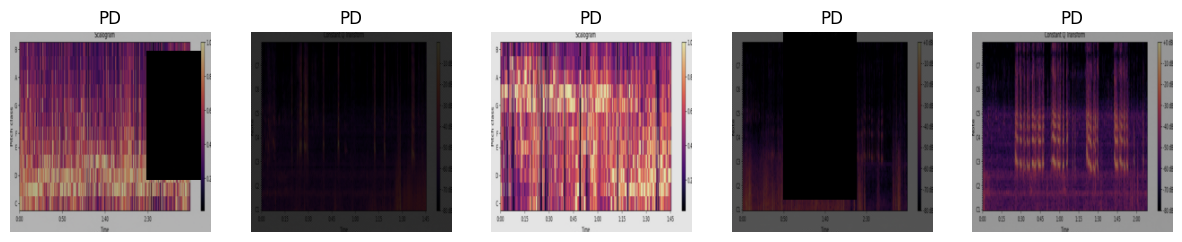

Class counts: [2308, 101]
Class balanced weights: tensor([0.0930, 1.9070])
Debug mode: 仅使用每个子集的前10个样本进行调试。
Epoch 1/10 ---------------------
Train Batch 0/1 - Current Loss: 1.5206
Epoch 1 Training Loss: 1.5206
Validation - Loss: 0.7826, Accuracy: 10.00%
Epoch 2/10 ---------------------
Train Batch 0/1 - Current Loss: 1.2888
Epoch 2 Training Loss: 1.2888
Validation - Loss: 0.7847, Accuracy: 0.00%
Epoch 3/10 ---------------------
Train Batch 0/1 - Current Loss: 1.0292
Epoch 3 Training Loss: 1.0292
Validation - Loss: 0.7246, Accuracy: 20.00%
Epoch 4/10 ---------------------
Train Batch 0/1 - Current Loss: 0.7869
Epoch 4 Training Loss: 0.7869
Validation - Loss: 0.6801, Accuracy: 40.00%
Epoch 5/10 ---------------------
Train Batch 0/1 - Current Loss: 0.5248
Epoch 5 Training Loss: 0.5248
Validation - Loss: 0.5388, Accuracy: 100.00%
Epoch 6/10 ---------------------
Train Batch 0/1 - Current Loss: 0.2773
Epoch 6 Training Loss: 0.2773
Validation - Loss: 0.4280, Accuracy: 100.00%
Epoch 7/10 -----

In [10]:
#测试，把debug_mode设置为True
import os
import random
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

########################################
# 预处理函数：去除背景与坐标轴文字
########################################
def crop_spectrogram(image, std_ratio=0.1):
    """
    利用图像灰度行列标准差自动检测边缘低信息区域，
    并裁剪掉这些区域，从而去除背景与坐标轴文字。
    :param image: PIL.Image，原始RGB图像
    :param std_ratio: 阈值比例，默认取最大标准差的10%
    :return: 裁剪后的图像
    """
    gray = image.convert('L')
    img_np = np.array(gray, dtype=np.float32)
    row_std = np.std(img_np, axis=1)
    col_std = np.std(img_np, axis=0)
    row_thresh = np.max(row_std) * std_ratio
    col_thresh = np.max(col_std) * std_ratio
    rows = np.where(row_std > row_thresh)[0]
    cols = np.where(col_std > col_thresh)[0]
    if rows.size == 0 or cols.size == 0:
        return image
    top, bottom = int(rows[0]), int(rows[-1])
    left, right = int(cols[0]), int(cols[-1])
    cropped = image.crop((left, top, right, bottom))
    return cropped

########################################
# 1. 数据集定义及划分
########################################
class SpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        """
        从指定根目录递归搜索所有文件夹名以 "Output" 结尾的png文件，
        并根据文件路径（文件名或父文件夹名称）判断标签：
        若包含 "pd"（忽略大小写），则认为是 PD 类，否则为 HC。
        """
        self.root_dir = root_dir
        self.transform = transform
        pattern = os.path.join(root_dir, '**', '*Output', '*.png')
        self.image_paths = glob.glob(pattern, recursive=True)
        
        if len(self.image_paths) == 0:
            raise ValueError("未在指定路径下找到任何符合条件的png文件，请检查文件目录。")
        
        self.labels = []
        for path in self.image_paths:
            path_lower = path.lower()
            folder_name = os.path.basename(os.path.dirname(path_lower))
            file_name = os.path.basename(path_lower)
            if "pd" in folder_name or "pd" in file_name:
                self.labels.append(1)
            else:
                self.labels.append(0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")
        # 根据文件名判断频谱图类型
        spec_type = "constantq" if "constantq" in img_path.lower() else (
                    "scalogram" if "scalogram" in img_path.lower() else "unknown")
        if self.transform:
            image = self.transform(image, spec_type)
        label = self.labels[idx]
        return image, label

########################################
# 2. 全局局部变换（Global-Local Transformation）及预处理整合
########################################
class GlobalLocalTransform:
    def __init__(self, output_size=(224, 224)):
        """
        :param output_size: 裁剪后统一缩放到的尺寸，默认 224×224
        """
        self.output_size = output_size
        self.local_transform = transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))

    def __call__(self, image, spec_type):
        # 预处理：裁剪去除背景与坐标轴文字
        image = crop_spectrogram(image, std_ratio=0.1)
        # 统一缩放到指定尺寸
        image = image.resize(self.output_size, Image.BILINEAR)
        # 转为Tensor
        image = transforms.ToTensor()(image)
        # 全局变换（傅里叶频域增强）
        image_global = self.global_transform(image, spec_type)
        # 局部随机擦除
        image_local = self.local_transform(image.clone())
        # 融合两部分
        alpha = random.uniform(0, 1)
        image_aug = alpha * image_global + (1 - alpha) * image_local
        image_aug = torch.clamp(image_aug, 0, 1)
        return image_aug

    def global_transform(self, image, spec_type):
        C, H, W = image.shape
        image_fft = torch.fft.fft2(image)
        cx, cy = W // 2, H // 2
        grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
        grid_x = grid_x.to(image.device)
        grid_y = grid_y.to(image.device)
        distance = torch.sqrt((grid_x - cx) ** 2 + (grid_y - cy) ** 2)
        if spec_type == "constantq":
            r = random.uniform(0.1, 0.3) * max(W, H)
        elif spec_type == "scalogram":
            r = random.uniform(0.2, 0.4) * max(W, H)
        else:
            r = random.uniform(0.1, 0.3) * max(W, H)
        mask = (distance < r).float().unsqueeze(0).repeat(C, 1, 1)
        noise = torch.randn_like(image_fft) * 0.1
        image_fft_aug = image_fft * mask + noise
        image_global = torch.fft.ifft2(image_fft_aug).real
        return image_global

########################################
# 3. 构建因果注意力网络（Causal SpectroNet）
########################################
class CausalSpectroNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CausalSpectroNet, self).__init__()
        backbone = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])
        self.attention = nn.Conv2d(512, 1, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)            # (B, 512, H, W)
        att_map = torch.sigmoid(self.attention(features)) # (B, 1, H, W)
        attended_features = features * att_map
        pooled = self.avgpool(attended_features)
        pooled = pooled.view(pooled.size(0), -1)
        logits = self.fc(pooled)
        return logits, att_map

########################################
# 4. 定义损失函数：Dice Loss 和 KL 散度
########################################
def dice_loss(att1, att2, eps=1e-6):
    att1_bin = (att1 > 0.5).float()
    att2_bin = (att2 > 0.5).float()
    intersection = (att1_bin * att2_bin).sum(dim=[1, 2, 3])
    union = att1_bin.sum(dim=[1, 2, 3]) + att2_bin.sum(dim=[1, 2, 3])
    loss = 1 - (2 * intersection + eps) / (union + eps)
    return loss.mean()

def kl_div_loss(p_logits, q_logits):
    p = torch.softmax(p_logits, dim=1)
    log_q = torch.log_softmax(q_logits, dim=1)
    loss = nn.KLDivLoss(reduction='batchmean')(log_q, p)
    return loss

########################################
# 5. 定义训练与验证函数
########################################
def train_epoch(model, dataloader, optimizer, device, class_weights, lambda_att=0.1, lambda_proto=0.1):
    model.train()
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        images_aug = images.clone()  # 简单克隆增强
        optimizer.zero_grad()
        logits_orig, att_orig = model(images)
        logits_aug, att_aug = model(images_aug)
        loss_cls = criterion(logits_orig, labels) + criterion(logits_aug, labels)
        loss_att = dice_loss(att_orig, att_aug)
        loss_proto = kl_div_loss(logits_orig, logits_aug) + kl_div_loss(logits_aug, logits_orig)
        loss = loss_cls + lambda_att * loss_att + lambda_proto * loss_proto
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"Train Batch {batch_idx}/{len(dataloader)} - Current Loss: {loss.item():.4f}")
    return running_loss / len(dataloader)

def validate_epoch(model, dataloader, device, class_weights):
    model.eval()
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            logits, _ = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    print(f"Validation - Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%")
    return avg_loss, accuracy

def print_dataset_info(dataset):
    total = len(dataset)
    PD_paths = [p for p, l in zip(dataset.image_paths, dataset.labels) if l == 1]
    HC_paths = [p for p, l in zip(dataset.image_paths, dataset.labels) if l == 0]
    print(f"Total samples in dataset: {total}")
    print(f"PD samples: {len(PD_paths)}")
    print(f"HC samples: {len(HC_paths)}")
    print("First PD sample paths:")
    for p in PD_paths[:5]:
        print(p)
    print("First 5 HC sample paths:")
    for p in HC_paths[:5]:
        print(p)

########################################
# 6. 可视化处理后的频谱图
########################################
def visualize_processed_images(dataset, num_images=5):
    """
    从数据集中取前 num_images 个样本，利用预处理变换，
    并将处理后的Tensor转换为PIL图像显示。
    """
    to_pil = transforms.ToPILImage()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        # image 为Tensor，转换为PIL Image后显示
        pil_img = to_pil(image)
        axes[i].imshow(pil_img)
        axes[i].set_title("PD" if label == 1 else "HC")
        axes[i].axis('off')
    plt.show()

########################################
# 7. 主程序：数据加载、均衡权重计算、训练与验证
########################################
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = GlobalLocalTransform(output_size=(224, 224))
    # 请确保传入正确的绝对路径
    full_dataset = SpectrogramDataset(root_dir="/Users/beibeiliu/paper/explore/Voice", transform=transform)
    
    # 打印数据集信息
    print_dataset_info(full_dataset)
    
    # 可视化处理后的频谱图
    print("展示处理后的前5张频谱图：")
    visualize_processed_images(full_dataset, num_images=5)
    
    # 计算类别均衡权重（参考 Cui et al., CVPR 2019）
    labels = full_dataset.labels
    num_classes = 2
    counts = [labels.count(i) for i in range(num_classes)]
    print("Class counts:", counts)
    beta = 0.9999
    weights = []
    for count in counts:
        effective_num = 1.0 - beta ** count
        weight = (1 - beta) / effective_num if effective_num != 0 else 0
        weights.append(weight)
    weights = torch.tensor(weights, dtype=torch.float)
    weights = weights / weights.sum() * num_classes
    print("Class balanced weights:", weights)
    
    # 划分数据集：80%训练，10%验证，10%测试
    total_len = len(full_dataset)
    train_len = int(0.8 * total_len)
    val_len = int(0.1 * total_len)
    test_len = total_len - train_len - val_len
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_len, val_len, test_len])
    
    # Debug模式：仅使用每个子集前10个样本调试
    debug_mode = True
    if debug_mode:
        train_dataset = torch.utils.data.Subset(train_dataset, list(range(min(10, len(train_dataset)))))
        val_dataset = torch.utils.data.Subset(val_dataset, list(range(min(10, len(val_dataset)))))
        test_dataset = torch.utils.data.Subset(test_dataset, list(range(min(10, len(test_dataset)))))
        print("Debug mode: 仅使用每个子集的前10个样本进行调试。")
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
    
    model = CausalSpectroNet(num_classes=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    num_epochs = 10
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} ---------------------")
        train_loss = train_epoch(model, train_loader, optimizer, device, class_weights=weights)
        print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")
        validate_epoch(model, val_loader, device, class_weights=weights)
    
    print("最终在测试集上评估：")
    validate_epoch(model, test_loader, device, class_weights=weights)
    
    torch.save(model.state_dict(), "causal_spectro_diagnosis.pth")
    
if __name__ == "__main__":
    main()


In [11]:
import os
import random
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

########################################
# 预处理函数：去除背景与坐标轴文字
########################################
def crop_spectrogram(image, std_ratio=0.1):
    """
    利用图像灰度行列标准差自动检测边缘低信息区域，
    并裁剪掉这些区域，从而去除背景与坐标轴文字。
    :param image: PIL.Image, 原始RGB图像
    :param std_ratio: 阈值比例，默认取最大标准差的10%
    :return: 裁剪后的图像
    """
    # 转换为灰度图（8位）
    gray = image.convert('L')
    img_np = np.array(gray, dtype=np.float32)
    # 分别计算每一行与每一列的标准差
    row_std = np.std(img_np, axis=1)
    col_std = np.std(img_np, axis=0)
    # 阈值设置为最大标准差的 std_ratio 倍
    row_thresh = np.max(row_std) * std_ratio
    col_thresh = np.max(col_std) * std_ratio
    rows = np.where(row_std > row_thresh)[0]
    cols = np.where(col_std > col_thresh)[0]
    if rows.size == 0 or cols.size == 0:
        return image  # 若没有检测到有效区域，返回原图
    top, bottom = int(rows[0]), int(rows[-1])
    left, right = int(cols[0]), int(cols[-1])
    cropped = image.crop((left, top, right, bottom))
    return cropped

########################################
# 1. 数据集定义及划分
########################################
class SpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        """
        从指定根目录下递归搜索所有文件夹名以 "Output" 结尾的png文件，
        同时根据文件名或所在目录判断标签：若路径中包含 "pd"（忽略大小写）则认为是 PD 类，否则为 HC。
        """
        self.root_dir = root_dir
        self.transform = transform
        pattern = os.path.join(root_dir, '**', '*Output', '*.png')
        self.image_paths = glob.glob(pattern, recursive=True)
        
        if len(self.image_paths) == 0:
            raise ValueError("未在指定路径下找到任何符合条件的png文件，请检查文件目录。")
        
        self.labels = []
        for path in self.image_paths:
            path_lower = path.lower()
            folder_name = os.path.basename(os.path.dirname(path_lower))
            file_name = os.path.basename(path_lower)
            if "pd" in folder_name or "pd" in file_name:
                self.labels.append(1)
            else:
                self.labels.append(0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")
        # 根据文件名判断频谱图类型
        spec_type = "constantq" if "constantq" in img_path.lower() else (
                    "scalogram" if "scalogram" in img_path.lower() else "unknown")
        if self.transform:
            image = self.transform(image, spec_type)
        label = self.labels[idx]
        return image, label

########################################
# 2. 全局局部变换（Global-Local Transformation）及预处理整合
########################################
class GlobalLocalTransform:
    def __init__(self, output_size=(224, 224)):
        """
        :param output_size: 预处理后将图像统一缩放到的尺寸，默认224×224（可根据任务需求调整）
        """
        self.output_size = output_size
        self.local_transform = transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))

    def __call__(self, image, spec_type):
        # 第一步：去除背景与坐标轴文字——利用灰度标准差裁剪
        image = crop_spectrogram(image, std_ratio=0.1)
        # 第二步：将裁剪后的图像统一缩放到固定大小（归一化标尺）
        image = image.resize(self.output_size, Image.BILINEAR)
        # 转换为Tensor
        image = transforms.ToTensor()(image)
        # 接下来进行原有的全局局部变换
        image_global = self.global_transform(image, spec_type)
        image_local = self.local_transform(image.clone())
        alpha = random.uniform(0, 1)
        image_aug = alpha * image_global + (1 - alpha) * image_local
        image_aug = torch.clamp(image_aug, 0, 1)
        return image_aug

    def global_transform(self, image, spec_type):
        # image: (C, H, W)
        C, H, W = image.shape
        image_fft = torch.fft.fft2(image)
        cx, cy = W // 2, H // 2
        grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
        grid_x = grid_x.to(image.device)
        grid_y = grid_y.to(image.device)
        distance = torch.sqrt((grid_x - cx) ** 2 + (grid_y - cy) ** 2)
        if spec_type == "constantq":
            r = random.uniform(0.1, 0.3) * max(W, H)
        elif spec_type == "scalogram":
            r = random.uniform(0.2, 0.4) * max(W, H)
        else:
            r = random.uniform(0.1, 0.3) * max(W, H)
        mask = (distance < r).float().unsqueeze(0).repeat(C, 1, 1)
        noise = torch.randn_like(image_fft) * 0.1
        image_fft_aug = image_fft * mask + noise
        image_global = torch.fft.ifft2(image_fft_aug).real
        return image_global

########################################
# 3. 构建因果注意力网络（Causal SpectroNet）
########################################
class CausalSpectroNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CausalSpectroNet, self).__init__()
        backbone = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])
        self.attention = nn.Conv2d(512, 1, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)            # (B, 512, H, W)
        att_map = torch.sigmoid(self.attention(features)) # (B, 1, H, W)
        attended_features = features * att_map
        pooled = self.avgpool(attended_features)
        pooled = pooled.view(pooled.size(0), -1)
        logits = self.fc(pooled)
        return logits, att_map

########################################
# 4. 定义损失函数：Dice Loss 和 KL 散度
########################################
def dice_loss(att1, att2, eps=1e-6):
    att1_bin = (att1 > 0.5).float()
    att2_bin = (att2 > 0.5).float()
    intersection = (att1_bin * att2_bin).sum(dim=[1, 2, 3])
    union = att1_bin.sum(dim=[1, 2, 3]) + att2_bin.sum(dim=[1, 2, 3])
    loss = 1 - (2 * intersection + eps) / (union + eps)
    return loss.mean()

def kl_div_loss(p_logits, q_logits):
    p = torch.softmax(p_logits, dim=1)
    log_q = torch.log_softmax(q_logits, dim=1)
    loss = nn.KLDivLoss(reduction='batchmean')(log_q, p)
    return loss

########################################
# 5. 定义训练与验证函数
########################################
def train_epoch(model, dataloader, optimizer, device, class_weights, lambda_att=0.1, lambda_proto=0.1):
    model.train()
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        images_aug = images.clone()  # 此处简单克隆增强，可扩展更多数据增强
        optimizer.zero_grad()
        logits_orig, att_orig = model(images)
        logits_aug, att_aug = model(images_aug)
        loss_cls = criterion(logits_orig, labels) + criterion(logits_aug, labels)
        loss_att = dice_loss(att_orig, att_aug)
        loss_proto = kl_div_loss(logits_orig, logits_aug) + kl_div_loss(logits_aug, logits_orig)
        loss = loss_cls + lambda_att * loss_att + lambda_proto * loss_proto
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"Train Batch {batch_idx}/{len(dataloader)} - Current Loss: {loss.item():.4f}")
    return running_loss / len(dataloader)

def validate_epoch(model, dataloader, device, class_weights):
    model.eval()
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            logits, _ = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    print(f"Validation - Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%")
    return avg_loss, accuracy

def print_dataset_info(dataset):
    total = len(dataset)
    PD_paths = [p for p, l in zip(dataset.image_paths, dataset.labels) if l == 1]
    HC_paths = [p for p, l in zip(dataset.image_paths, dataset.labels) if l == 0]
    print(f"Total samples in dataset: {total}")
    print(f"PD samples: {len(PD_paths)}")
    print(f"HC samples: {len(HC_paths)}")
    print("First PD sample paths:")
    for p in PD_paths[:5]:
        print(p)
    print("First 5 HC sample paths:")
    for p in HC_paths[:5]:
        print(p)

########################################
# 6. 主程序：数据加载、均衡权重计算、训练与验证
########################################
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = GlobalLocalTransform(output_size=(224, 224))
    # 请确保传入正确的绝对路径
    full_dataset = SpectrogramDataset(root_dir="/Users/beibeiliu/paper/explore/Voice", transform=transform)
    
    # 打印数据集信息
    print_dataset_info(full_dataset)
    
    # 计算类别均衡权重（参考 Cui et al., CVPR 2019）
    labels = full_dataset.labels
    num_classes = 2
    counts = [labels.count(i) for i in range(num_classes)]
    print("Class counts:", counts)
    beta = 0.9999
    weights = []
    for count in counts:
        effective_num = 1.0 - beta ** count
        weight = (1 - beta) / effective_num if effective_num != 0 else 0
        weights.append(weight)
    weights = torch.tensor(weights, dtype=torch.float)
    # 归一化：使权重和等于类别数（例如2）
    weights = weights / weights.sum() * num_classes
    print("Class balanced weights:", weights)
    
    # 划分数据集：80%训练，10%验证，10%测试
    total_len = len(full_dataset)
    train_len = int(0.8 * total_len)
    val_len = int(0.1 * total_len)
    test_len = total_len - train_len - val_len
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_len, val_len, test_len])
    
    # Debug模式下，仅使用每个子集前10个样本调试
    debug_mode = False
    if debug_mode:
        train_dataset = torch.utils.data.Subset(train_dataset, list(range(min(10, len(train_dataset)))))
        val_dataset = torch.utils.data.Subset(val_dataset, list(range(min(10, len(val_dataset)))))
        test_dataset = to rch.utils.data.Subset(test_dataset, list(range(min(10, len(test_dataset)))))
        print("Debug mode: 仅使用每个子集的前10个样本进行调试。")
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
    
    model = CausalSpectroNet(num_classes=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    num_epochs = 10
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} ---------------------")
        train_loss = train_epoch(model, train_loader, optimizer, device, class_weights=weights)
        print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")
        validate_epoch(model, val_loader, device, class_weights=weights)
    
    print("最终在测试集上评估：")
    validate_epoch(model, test_loader, device, class_weights=weights)
    
    torch.save(model.state_dict(), "causal_spectro_diagnosis.pth")
    
if __name__ == "__main__":
    main()


Total samples in dataset: 2409
PD samples: 101
HC samples: 2308
First PD sample paths:
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_scalogram.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_PD_Output/ID32_pd_3_1_1_constantq.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_PD_Output/ID32_pd_3_1_1_scalogram.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_constantq.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_PD_Output/ID06_pd_3_1_1_constantq.png
First 5 HC sample paths:
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_HC_Output/ID09_hc_0_0_0_constantq.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_HC_Output/ID00_hc_0_0_0_scalogram.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_HC_Output/ID03_hc_0_0_0_constantq.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_HC_Output/ID35_hc_0_0_0_constantq.png
/Users/beibeiliu/paper/explore/Voice/KCL_Spontaneous_HC_Output/ID36_h

In [ ]:
#wav转频谱

In [3]:
import os
import glob
import librosa
import numpy as np
from PIL import Image
from tqdm import tqdm
import soundfile as sf
import matplotlib.pyplot as plt

def remove_generated_pngs(root_dir):
    """
    删除 root_dir 下所有递归查找到的 .png 文件
    """
    png_files = glob.glob(os.path.join(root_dir, '**', '*.png'), recursive=True)
    for file in png_files:
        try:
            os.remove(file)
        except Exception as e:
            print(f"删除 {file} 失败：{e}")

def remove_silence(audio, sr, top_db=20):
    """
    利用 librosa.effects.split 检测并去除音频中的静音片段
    :param audio: 1D numpy 数组，音频信号
    :param sr: 采样率
    :param top_db: 静音判定的阈值
    :return: 去除静音后的音频信号
    """
    intervals = librosa.effects.split(audio, top_db=top_db)
    if len(intervals) == 0:
        return audio
    return np.concatenate([audio[start:end] for start, end in intervals])

def generate_stft_spectrogram(audio, sr, n_fft=2048, hop_length=512):
    """
    生成 STFT 频谱图（单位 dB）
    """
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    return S_db

def generate_mel_spectrogram(audio, sr, n_fft=2048, hop_length=512, n_mels=128):
    """
    生成 Mel 频谱图（单位 dB）
    """
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, 
                                              hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def generate_cqt_spectrogram(audio, sr, hop_length=512, bins_per_octave=12, n_bins=84):
    """
    生成 CQT（恒 Q 变换）频谱图（单位 dB）
    """
    C = np.abs(librosa.cqt(audio, sr=sr, hop_length=hop_length, 
                           bins_per_octave=bins_per_octave, n_bins=n_bins))
    C_db = librosa.amplitude_to_db(C, ref=np.max)
    return C_db

def save_color_spectrogram(spectrogram, output_file, cmap='viridis'):
    """
    将频谱图归一化后利用 matplotlib colormap 生成彩色图谱，并保存为图像
    """
    # 归一化：spectrogram 一般范围是负值到 0 dB
    min_val = np.min(spectrogram)
    max_val = 0  # 0 dB 为最大值
    norm_spec = (spectrogram - min_val) / (max_val - min_val)  # 范围 [0,1]
    
    # 获取 colormap 对象，并将归一化后的数组映射为 RGBA 值（范围 [0,1]）
    cmap_obj = plt.get_cmap(cmap)
    colored = cmap_obj(norm_spec)  # shape: (height, width, 4)
    
    # 去除 alpha 通道，转换到 [0,255] 并转为 uint8
    colored_rgb = (colored[:, :, :3] * 255).astype(np.uint8)
    image = Image.fromarray(colored_rgb)
    image.save(output_file)

def segment_audio(audio, sr, segment_length=1.0):
    """
    将音频切割成固定长度（单位秒）的片段，不足一秒的部分忽略
    :param audio: 音频信号
    :param sr: 采样率
    :param segment_length: 片段时长（秒）
    :return: 包含各片段的列表
    """
    segment_samples = int(sr * segment_length)
    total_samples = len(audio)
    num_segments = total_samples // segment_samples
    segments = []
    for i in range(num_segments):
        start = i * segment_samples
        end = start + segment_samples
        segments.append(audio[start:end])
    return segments

def load_progress(progress_file):
    """
    加载已处理文件的列表，返回一个 set
    """
    processed = set()
    if os.path.exists(progress_file):
        with open(progress_file, "r", encoding="utf-8") as f:
            for line in f:
                processed.add(line.strip())
    return processed

def update_progress(progress_file, file_path):
    """
    将处理过的文件路径追加写入进度记录文件
    """
    with open(progress_file, "a", encoding="utf-8") as f:
        f.write(file_path + "\n")

def process_all_wav_files(root_dir, standard_dir, sample_rate=22050, n_fft=2048, hop_length=512, top_db=20):
    """
    处理 root_dir 下所有 .wav 文件：
      1. 加载后提取非静音部分
      2. 切割成 1 秒片段，并保存到 standard_dir（保存为 wav 文件）
      3. 对每个片段生成 3 种彩色频谱图（STFT、Mel、CQT）
      4. 根据文件名中是否含有 "pd" 或 "hc"判断类别，保存到 standard_dir/PD 或 standard_dir/HC 下
      5. 记录处理进度，下次可以继续未完成的文件
    """
    # 创建标准化存放文件夹及子文件夹
    pd_dir = os.path.join(standard_dir, 'PD')
    hc_dir = os.path.join(standard_dir, 'HC')
    os.makedirs(standard_dir, exist_ok=True)
    os.makedirs(pd_dir, exist_ok=True)
    os.makedirs(hc_dir, exist_ok=True)
    
    # 进度记录文件路径
    progress_file = os.path.join(standard_dir, "progress.txt")
    processed_files = load_progress(progress_file)
    
    # 查找所有 wav 文件
    wav_files = glob.glob(os.path.join(root_dir, '**', '*.wav'), recursive=True)
    # 过滤掉已经处理过的文件
    wav_files_to_process = [f for f in wav_files if f not in processed_files]
    
    for file_path in tqdm(wav_files_to_process, desc="Processing WAV files"):
        try:
            # 加载音频
            audio, sr = librosa.load(file_path, sr=sample_rate)
        except Exception as e:
            print(f"加载 {file_path} 失败：{e}")
            continue
        
        # 去除静音
        audio_nonsilence = remove_silence(audio, sr, top_db=top_db)
        # 切割成 1 秒片段
        segments = segment_audio(audio_nonsilence, sr, segment_length=1.0)
        
        # 根据文件路径判断类别（如果文件名中包含 "pd" 则归为 PD，否则归为 HC）
        lower_path = file_path.lower()
        if "pd" in lower_path:
            category = 'PD'
        elif "hc" in lower_path:
            category = 'HC'
        else:
            category = 'HC'
        
        # 处理每个片段
        for idx, segment in enumerate(segments):
            base_name = f"{os.path.splitext(os.path.basename(file_path))[0]}_seg{idx}"
            
            # 保存音频片段到 standard_dir 中（wav 格式）
            segment_wav_file = os.path.join(standard_dir, base_name + ".wav")
            try:
                sf.write(segment_wav_file, segment, sr)
            except Exception as e:
                print(f"保存音频 {segment_wav_file} 失败：{e}")
            
            # 生成 3 种彩色频谱图
            stft_spec = generate_stft_spectrogram(segment, sr, n_fft=n_fft, hop_length=hop_length)
            mel_spec = generate_mel_spectrogram(segment, sr, n_fft=n_fft, hop_length=hop_length)
            cqt_spec = generate_cqt_spectrogram(segment, sr, hop_length=hop_length)
            
            # 构造频谱图保存路径，根据类别放到 PD 或 HC 文件夹下
            target_dir = pd_dir if category == 'PD' else hc_dir
            stft_file = os.path.join(target_dir, base_name + "_stft.png")
            mel_file = os.path.join(target_dir, base_name + "_mel.png")
            cqt_file = os.path.join(target_dir, base_name + "_cqt.png")
            
            try:
                save_color_spectrogram(stft_spec, stft_file)
                save_color_spectrogram(mel_spec, mel_file)
                save_color_spectrogram(cqt_spec, cqt_file)
            except Exception as e:
                print(f"保存频谱图失败（{base_name}）：{e}")
        
        # 当前文件处理完成后记录进度
        update_progress(progress_file, file_path)

if __name__ == "__main__":
    # 语音文件所在根目录
    root_wav_dir = "./Voice"
    # 标准化输出文件夹（包含切割后的音频和频谱图）
    standard_dir = os.path.join(root_wav_dir, "standard")
    
    # 删除之前生成的 png 文件
    remove_generated_pngs(root_wav_dir)
    
    # 开始处理所有 wav 文件
    process_all_wav_files(root_wav_dir, standard_dir)


Processing WAV files: 100%|█████████████████| 4683/4683 [02:02<00:00, 38.38it/s]


In [4]:
import os
import glob
import librosa
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

def generate_stft_spectrogram(audio, sr, n_fft=2048, hop_length=512):
    """
    生成 STFT 频谱图（单位 dB）
    """
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    return S_db

def generate_mel_spectrogram(audio, sr, n_fft=2048, hop_length=512, n_mels=128):
    """
    生成 Mel 频谱图（单位 dB）
    """
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, 
                                              hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def generate_cqt_spectrogram(audio, sr, hop_length=512, bins_per_octave=12, n_bins=84):
    """
    生成 CQT（恒 Q 变换）频谱图（单位 dB）
    """
    C = np.abs(librosa.cqt(audio, sr=sr, hop_length=hop_length, 
                           bins_per_octave=bins_per_octave, n_bins=n_bins))
    C_db = librosa.amplitude_to_db(C, ref=np.max)
    return C_db

def save_color_spectrogram(spectrogram, output_file, cmap='viridis'):
    """
    将频谱图归一化后利用 matplotlib colormap 生成彩色图谱，并保存为图像
    """
    # 归一化：spectrogram 的值一般在负值到 0 之间
    min_val = np.min(spectrogram)
    max_val = 0  # 0 dB 为最大值
    norm_spec = (spectrogram - min_val) / (max_val - min_val)  # 归一化到 [0, 1]
    
    # 将归一化后的频谱图映射为彩色（RGBA）
    cmap_obj = plt.get_cmap(cmap)
    colored = cmap_obj(norm_spec)
    
    # 去除 alpha 通道，并转换到 [0,255]
    colored_rgb = (colored[:, :, :3] * 255).astype(np.uint8)
    image = Image.fromarray(colored_rgb)
    image.save(output_file)

def process_hc_wav_files(hc_folder, sample_rate=22050):
    """
    处理 HC 文件夹中的所有 wav 文件：
      1. 加载音频文件
      2. 分别生成 STFT、Mel 和 CQT 彩色频谱图
      3. 保存生成的图谱（文件名格式：原文件名 + 后缀）
    """
    wav_files = glob.glob(os.path.join(hc_folder, '*.wav'))
    for file_path in tqdm(wav_files, desc="Processing HC WAV files"):
        try:
            audio, sr = librosa.load(file_path, sr=sample_rate)
        except Exception as e:
            print(f"加载 {file_path} 失败：{e}")
            continue
        
        # 生成三种频谱图
        stft_spec = generate_stft_spectrogram(audio, sr)
        mel_spec = generate_mel_spectrogram(audio, sr)
        cqt_spec = generate_cqt_spectrogram(audio, sr)
        
        # 构造保存文件名
        base_name = os.path.splitext(os.path.basename(file_path))[0]
        stft_file = os.path.join(hc_folder, base_name + '_stft.png')
        mel_file = os.path.join(hc_folder, base_name + '_mel.png')
        cqt_file = os.path.join(hc_folder, base_name + '_cqt.png')
        
        try:
            save_color_spectrogram(stft_spec, stft_file)
            save_color_spectrogram(mel_spec, mel_file)
            save_color_spectrogram(cqt_spec, cqt_file)
        except Exception as e:
            print(f"保存频谱图失败（{base_name}）：{e}")

if __name__ == "__main__":
    # HC 文件夹的绝对路径，请根据实际情况修改
    hc_folder = "/Users/beibeiliu/paper/explore/Voice/standard/HC"
    process_hc_wav_files(hc_folder)


Processing HC WAV files: 100%|██████████████| 4395/4395 [01:53<00:00, 38.74it/s]


In [3]:
import os
import glob
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

########################################
# 数据集定义：根据频谱类型加载图像，并划分 HC (0) 和 PD (1)
########################################
class SpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, spec_type, transform=None):
        """
        从指定根目录下加载图像。
        假设数据存放在 Voice/standard/HC 与 Voice/standard/PD 下，
        只加载文件名中包含指定 spec_type（如 "cqt", "mel", "stft"）的图像。
        标签：HC -> 0, PD -> 1.
        """
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label, class_name in enumerate(["HC", "PD"]):
            folder = os.path.join(root_dir, class_name)
            pattern = os.path.join(folder, f"*{spec_type}*.png")
            paths = glob.glob(pattern)
            self.image_paths.extend(paths)
            self.labels.extend([label] * len(paths))
        if len(self.image_paths) == 0:
            raise ValueError(f"未在 {root_dir} 下找到符合 {spec_type} 的 png 文件，请检查路径！")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"加载图像 {img_path} 出错: {e}")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

########################################
# 计算类别权重（采用有效数方法）
########################################
def compute_class_weights(dataset, beta=0.9999, num_classes=2):
    counts = [0] * num_classes
    # 如果是 Subset，则从原始数据集中取出对应标签
    if hasattr(dataset, "indices"):
        labels = [dataset.dataset.labels[i] for i in dataset.indices]
    else:
        labels = dataset.labels
    for label in labels:
        counts[label] += 1
    weights = []
    for count in counts:
        effective_num = 1 - beta ** count
        weight = (1 - beta) / effective_num if effective_num != 0 else 0
        weights.append(weight)
    weights = torch.tensor(weights, dtype=torch.float)
    weights = weights / weights.sum() * num_classes
    return weights

########################################
# 定义分类模型：基于预训练 ResNet18
########################################
def get_model(num_classes=2):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

########################################
# 训练单个分支：包含数据集划分、训练和验证进度显示
########################################
def train_branch(spec_type, root_dir, num_epochs=10, batch_size=32, lr=1e-4, device="cuda"):
    print(f"\nTraining branch for spec_type: {spec_type}")
    transform = transforms.Compose([
        transforms.ToTensor(),
        # 可以加入数据增强，如 RandomHorizontalFlip(), ColorJitter(), 等
    ])
    # 加载数据集并划分 80/10/10
    full_dataset = SpectrogramDataset(root_dir=root_dir, spec_type=spec_type, transform=transform)
    total_len = len(full_dataset)
    train_len = int(0.8 * total_len)
    val_len = int(0.1 * total_len)
    test_len = total_len - train_len - val_len
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_len, val_len, test_len])
    class_weights = compute_class_weights(train_dataset)
    print(f"Dataset {spec_type} - Total: {total_len}, Train: {train_len}, Val: {val_len}, Test: {test_len}")
    print(f"Class weights for {spec_type}: {class_weights}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    model = get_model(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training {spec_type} Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / train_len
        print(f"Epoch {epoch+1} Training Loss: {epoch_loss:.4f}")
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validation {spec_type} Epoch {epoch+1}/{num_epochs}"):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        avg_val_loss = val_loss / val_len
        accuracy = correct / total
        print(f"Epoch {epoch+1} Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy*100:.2f}%")
    
    # 保存模型，并返回训练好的模型和测试集以备后续评估
    model_path = f"model_{spec_type}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Saved model for {spec_type} at {model_path}")
    return model, test_dataset

########################################
# GradCAM 类实现，用于提取特定类别特征热图
########################################
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_tensor, target_class):
        self.model.zero_grad()
        output = self.model(input_tensor)[0]
        score = output[0, target_class]
        score.backward()
        gradients = self.gradients  # [1, C, H, W]
        activations = self.activations  # [1, C, H, W]
        weights = gradients.mean(dim=(2,3), keepdim=True)
        gradcam_map = torch.relu((weights * activations).sum(dim=1, keepdim=True))
        gradcam_map = torch.nn.functional.interpolate(gradcam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        gradcam_map = gradcam_map.squeeze().cpu().numpy()
        gradcam_map = (gradcam_map - gradcam_map.min()) / (gradcam_map.max() - gradcam_map.min() + 1e-8)
        return gradcam_map

########################################
# GradCAM 可视化函数：展示热图与原图融合结果，并给出解读
########################################
def visualize_gradcam(spec_type, sample_path, model, device="cuda"):
    transform = transforms.ToTensor()
    image = Image.open(sample_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    # 对 ResNet18，最后一个卷积层一般取 model.layer4
    target_layer = model.layer4
    gradcam = GradCAM(model, target_layer)
    # 假设我们关注 PD 类（标签1）
    cam_map = gradcam(input_tensor, target_class=1)
    gradcam.remove_hooks()
    
    # 将 cam_map 映射到颜色热图，并叠加到原图上
    img_np = np.array(image)
    heatmap = plt.get_cmap("jet")(cam_map)[:, :, :3]  # (H, W, 3)
    heatmap = np.uint8(255 * heatmap)
    overlay = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title(f"Original {spec_type}")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(cam_map, cmap="jet")
    plt.title("GradCAM Heatmap")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")
    plt.show()
    
    # 解读：观察热图可发现，若模型学到了PD的特有特征，
    # 则在 PD 频谱图中往往会在某些特定频率或时间段出现较高响应，
    # 这可能反映了 PD 病理状态下的异常能量分布或震颤现象。
    print("解读：从热图中可以看出，模型在图像的（例如低频或高能量区域）区域具有较高激活，")
    print("这表明这些区域可能对应于 PD 样本中具有判别性或因果作用的特征模式。")

########################################
# 主函数：训练三个分支并演示 GradCAM 分析
########################################
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    root_dir = "./Voice/standard"  # 包含 HC 和 PD 文件夹
    spec_types = ["cqt", "mel", "stft"]
    models_dict = {}
    test_datasets = {}
    for spec in spec_types:
        model, test_ds = train_branch(spec_type=spec, root_dir=root_dir, num_epochs=10, batch_size=32, lr=1e-4, device=device)
        models_dict[spec] = model
        test_datasets[spec] = test_ds

    # 假设我们选取一个 PD 类样本进行 GradCAM 分析，此处以 cqt 分支为例
    # 注意：请根据实际情况修改 sample_path 指向一个 PD 样本的 cqt 图像
    sample_path = os.path.join(root_dir, "PD", "example_pd_cqt.png")
    print("\nGradCAM visualization for PD sample (cqt):")
    visualize_gradcam("cqt", sample_path, models_dict["cqt"], device=device)

if __name__ == "__main__":
    # 注意：需要安装 cv2，可使用 
    import cv2
    main()



Training branch for spec_type: cqt
Dataset cqt - Total: 5765, Train: 4612, Val: 576, Test: 577
Class weights for cqt: tensor([0.5221, 1.4779])


/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training cqt Epoch 1/10: 100%|████████████████| 145/145 [01:02<00:00,  2.33it/s]


Epoch 1 Training Loss: 0.6182


Validation cqt Epoch 1/10: 100%|████████████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 1 Val Loss: 0.5625, Accuracy: 66.32%


Training cqt Epoch 2/10: 100%|████████████████| 145/145 [01:01<00:00,  2.34it/s]


Epoch 2 Training Loss: 0.4903


Validation cqt Epoch 2/10: 100%|████████████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch 2 Val Loss: 0.5807, Accuracy: 64.93%


Training cqt Epoch 3/10: 100%|████████████████| 145/145 [01:01<00:00,  2.34it/s]


Epoch 3 Training Loss: 0.4426


Validation cqt Epoch 3/10: 100%|████████████████| 18/18 [00:04<00:00,  3.86it/s]


Epoch 3 Val Loss: 0.7052, Accuracy: 65.97%


Training cqt Epoch 4/10: 100%|████████████████| 145/145 [01:01<00:00,  2.36it/s]


Epoch 4 Training Loss: 0.4132


Validation cqt Epoch 4/10: 100%|████████████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 4 Val Loss: 0.8223, Accuracy: 65.28%


Training cqt Epoch 5/10: 100%|████████████████| 145/145 [01:01<00:00,  2.37it/s]


Epoch 5 Training Loss: 0.3961


Validation cqt Epoch 5/10: 100%|████████████████| 18/18 [00:04<00:00,  4.01it/s]


Epoch 5 Val Loss: 1.0040, Accuracy: 63.72%


Training cqt Epoch 6/10: 100%|████████████████| 145/145 [01:02<00:00,  2.32it/s]


Epoch 6 Training Loss: 0.3976


Validation cqt Epoch 6/10: 100%|████████████████| 18/18 [00:04<00:00,  3.91it/s]


Epoch 6 Val Loss: 1.0716, Accuracy: 63.02%


Training cqt Epoch 7/10: 100%|████████████████| 145/145 [01:02<00:00,  2.34it/s]


Epoch 7 Training Loss: 0.3834


Validation cqt Epoch 7/10: 100%|████████████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 7 Val Loss: 1.1331, Accuracy: 63.37%


Training cqt Epoch 8/10: 100%|████████████████| 145/145 [01:03<00:00,  2.27it/s]


Epoch 8 Training Loss: 0.3797


Validation cqt Epoch 8/10: 100%|████████████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 8 Val Loss: 1.0542, Accuracy: 62.67%


Training cqt Epoch 9/10: 100%|████████████████| 145/145 [01:30<00:00,  1.61it/s]


Epoch 9 Training Loss: 0.3853


Validation cqt Epoch 9/10: 100%|████████████████| 18/18 [00:08<00:00,  2.19it/s]


Epoch 9 Val Loss: 1.3859, Accuracy: 64.06%


Training cqt Epoch 10/10: 100%|███████████████| 145/145 [01:56<00:00,  1.25it/s]


Epoch 10 Training Loss: 0.4318


Validation cqt Epoch 10/10: 100%|███████████████| 18/18 [00:08<00:00,  2.25it/s]


Epoch 10 Val Loss: 0.9122, Accuracy: 63.89%
Saved model for cqt at model_cqt.pth

Training branch for spec_type: mel
Dataset mel - Total: 5765, Train: 4612, Val: 576, Test: 577
Class weights for mel: tensor([0.5213, 1.4787])


Training mel Epoch 1/10: 100%|████████████████| 145/145 [02:10<00:00,  1.11it/s]


Epoch 1 Training Loss: 0.6257


Validation mel Epoch 1/10: 100%|████████████████| 18/18 [00:08<00:00,  2.03it/s]


Epoch 1 Val Loss: 0.5668, Accuracy: 67.19%


Training mel Epoch 2/10: 100%|████████████████| 145/145 [02:12<00:00,  1.09it/s]


Epoch 2 Training Loss: 0.4894


Validation mel Epoch 2/10: 100%|████████████████| 18/18 [00:08<00:00,  2.06it/s]


Epoch 2 Val Loss: 0.5722, Accuracy: 67.19%


Training mel Epoch 3/10: 100%|████████████████| 145/145 [02:11<00:00,  1.10it/s]


Epoch 3 Training Loss: 0.4302


Validation mel Epoch 3/10: 100%|████████████████| 18/18 [00:09<00:00,  1.82it/s]


Epoch 3 Val Loss: 0.5585, Accuracy: 64.24%


Training mel Epoch 4/10: 100%|██████████████| 145/145 [3:00:28<00:00, 74.68s/it]


Epoch 4 Training Loss: 0.4133


Validation mel Epoch 4/10: 100%|████████████████| 18/18 [00:05<00:00,  3.52it/s]


Epoch 4 Val Loss: 0.6365, Accuracy: 68.58%


Training mel Epoch 5/10: 100%|████████████████| 145/145 [01:13<00:00,  1.98it/s]


Epoch 5 Training Loss: 0.3857


Validation mel Epoch 5/10: 100%|████████████████| 18/18 [00:05<00:00,  3.59it/s]


Epoch 5 Val Loss: 0.6653, Accuracy: 64.93%


Training mel Epoch 6/10: 100%|████████████████| 145/145 [01:10<00:00,  2.07it/s]


Epoch 6 Training Loss: 0.3840


Validation mel Epoch 6/10: 100%|████████████████| 18/18 [00:04<00:00,  3.70it/s]


Epoch 6 Val Loss: 0.7661, Accuracy: 66.49%


Training mel Epoch 7/10: 100%|████████████████| 145/145 [01:11<00:00,  2.04it/s]


Epoch 7 Training Loss: 0.3892


Validation mel Epoch 7/10: 100%|████████████████| 18/18 [00:05<00:00,  3.50it/s]


Epoch 7 Val Loss: 0.7822, Accuracy: 66.32%


Training mel Epoch 8/10: 100%|████████████████| 145/145 [01:12<00:00,  2.00it/s]


Epoch 8 Training Loss: 0.3710


Validation mel Epoch 8/10: 100%|████████████████| 18/18 [00:05<00:00,  3.34it/s]


Epoch 8 Val Loss: 1.4298, Accuracy: 66.32%


Training mel Epoch 9/10: 100%|████████████████| 145/145 [01:14<00:00,  1.95it/s]


Epoch 9 Training Loss: 0.3792


Validation mel Epoch 9/10: 100%|████████████████| 18/18 [00:05<00:00,  3.39it/s]


Epoch 9 Val Loss: 0.8661, Accuracy: 65.45%


Training mel Epoch 10/10: 100%|███████████████| 145/145 [01:11<00:00,  2.02it/s]


Epoch 10 Training Loss: 0.3681


Validation mel Epoch 10/10: 100%|███████████████| 18/18 [00:05<00:00,  3.44it/s]


Epoch 10 Val Loss: 1.2006, Accuracy: 65.45%
Saved model for mel at model_mel.pth

Training branch for spec_type: stft
Dataset stft - Total: 5765, Train: 4612, Val: 576, Test: 577
Class weights for stft: tensor([0.5225, 1.4775])


Training stft Epoch 1/10: 100%|███████████████| 145/145 [05:15<00:00,  2.18s/it]


Epoch 1 Training Loss: 0.5948


Validation stft Epoch 1/10: 100%|███████████████| 18/18 [00:19<00:00,  1.10s/it]


Epoch 1 Val Loss: 0.6167, Accuracy: 53.12%


Training stft Epoch 2/10: 100%|███████████████| 145/145 [05:18<00:00,  2.19s/it]


Epoch 2 Training Loss: 0.5026


Validation stft Epoch 2/10: 100%|███████████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 2 Val Loss: 0.5937, Accuracy: 71.53%


Training stft Epoch 3/10: 100%|███████████████| 145/145 [05:20<00:00,  2.21s/it]


Epoch 3 Training Loss: 0.4755


Validation stft Epoch 3/10: 100%|███████████████| 18/18 [00:19<00:00,  1.06s/it]


Epoch 3 Val Loss: 0.5472, Accuracy: 68.75%


Training stft Epoch 4/10: 100%|███████████████| 145/145 [05:29<00:00,  2.27s/it]


Epoch 4 Training Loss: 0.4464


Validation stft Epoch 4/10: 100%|███████████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch 4 Val Loss: 0.5782, Accuracy: 57.12%


Training stft Epoch 5/10: 100%|███████████████| 145/145 [05:23<00:00,  2.23s/it]


Epoch 5 Training Loss: 0.4231


Validation stft Epoch 5/10: 100%|███████████████| 18/18 [00:19<00:00,  1.07s/it]


Epoch 5 Val Loss: 0.5672, Accuracy: 68.58%


Training stft Epoch 6/10: 100%|███████████████| 145/145 [05:24<00:00,  2.24s/it]


Epoch 6 Training Loss: 0.4239


Validation stft Epoch 6/10: 100%|███████████████| 18/18 [00:19<00:00,  1.11s/it]


Epoch 6 Val Loss: 0.6745, Accuracy: 68.06%


Training stft Epoch 7/10: 100%|███████████████| 145/145 [05:33<00:00,  2.30s/it]


Epoch 7 Training Loss: 0.3942


Validation stft Epoch 7/10: 100%|███████████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch 7 Val Loss: 0.6440, Accuracy: 59.38%


Training stft Epoch 8/10: 100%|███████████████| 145/145 [05:20<00:00,  2.21s/it]


Epoch 8 Training Loss: 0.3928


Validation stft Epoch 8/10: 100%|███████████████| 18/18 [00:19<00:00,  1.09s/it]


Epoch 8 Val Loss: 0.8801, Accuracy: 67.36%


Training stft Epoch 9/10: 100%|███████████████| 145/145 [05:15<00:00,  2.18s/it]


Epoch 9 Training Loss: 0.3822


Validation stft Epoch 9/10: 100%|███████████████| 18/18 [00:19<00:00,  1.08s/it]


Epoch 9 Val Loss: 0.7254, Accuracy: 63.72%


Training stft Epoch 10/10: 100%|██████████████| 145/145 [05:17<00:00,  2.19s/it]


Epoch 10 Training Loss: 0.3759


Validation stft Epoch 10/10: 100%|██████████████| 18/18 [00:19<00:00,  1.09s/it]


Epoch 10 Val Loss: 0.9383, Accuracy: 64.24%
Saved model for stft at model_stft.pth

GradCAM visualization for PD sample (cqt):


FileNotFoundError: [Errno 2] No such file or directory: './Voice/standard/PD/example_pd_cqt.png'

Processing 4395 images for HC cqt ...
Processing 4395 images for HC mel ...
Processing 4395 images for HC stft ...
Processing 1370 images for PD cqt ...
Processing 1370 images for PD mel ...
Processing 1370 images for PD stft ...


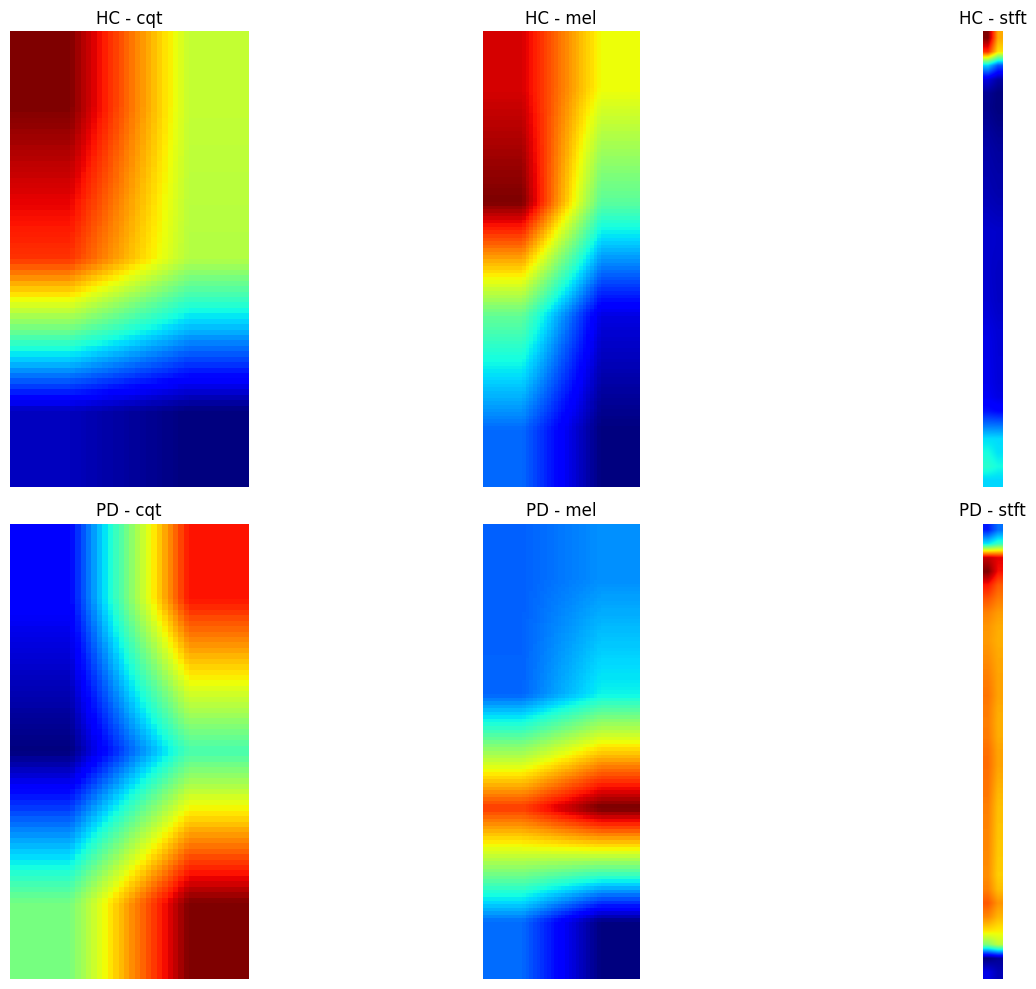

【解读】
从平均 GradCAM 热图可以观察到：
1. 对于 PD 类样本，若模型捕捉到了该类别的独特特征，
   则在某些频谱图（例如 cqt 或 mel）中可能在特定频率段或时间段出现较高的激活区域，
   这可能反映出 PD 病理状态下异常的能量分布或震颤现象。
2. 而 HC 类样本的热图则显示出激活区域较为分散或在关键区域的响应较弱。
这种方法借鉴了 Grad-CAM (Selvaraju et al., 2017) 和 Score-CAM 方法，
通过对一组样本的热图平均，可以获得每个类别在特定频谱下的典型特征模式。


In [6]:
import os
import glob
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models

########################################
# GradCAM 实现（修正输出维度问题）
########################################
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
        
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))
        
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
            
    def __call__(self, input_tensor, target_class):
        self.model.zero_grad()
        output = self.model(input_tensor)
        # 针对目标类别计算梯度。判断输出的维度：
        if output.dim() == 1:
            score = output[target_class]
        elif output.dim() == 2:
            score = output[0, target_class]
        else:
            raise ValueError("Unexpected output dimension")
        score.backward()
        gradients = self.gradients  # shape: [1, C, H, W]
        activations = self.activations  # shape: [1, C, H, W]
        weights = gradients.mean(dim=(2, 3), keepdim=True)  # [1, C, 1, 1]
        cam_map = torch.relu((weights * activations).sum(dim=1, keepdim=True))
        cam_map = torch.nn.functional.interpolate(cam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam_map = cam_map.squeeze().cpu().numpy()
        cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min() + 1e-8)
        return cam_map

########################################
# 获取指定类别和频谱类型的图像路径
########################################
def get_image_paths(root_dir, class_name, spec_type):
    # 数据存放在 Voice/standard/HC 与 Voice/standard/PD 下
    folder = os.path.join(root_dir, class_name)
    pattern = os.path.join(folder, f"*{spec_type}*.png")
    paths = glob.glob(pattern)
    return paths

########################################
# 对给定图像列表计算平均 GradCAM 热图
########################################
def compute_average_gradcam(model, image_paths, target_class, device="cuda"):
    transform = transforms.ToTensor()
    gradcam = GradCAM(model, model.layer4)  # 对于 ResNet18，使用最后一个卷积层 layer4
    cam_maps = []
    for path in image_paths:
        image = Image.open(path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)
        cam_map = gradcam(input_tensor, target_class)
        cam_maps.append(cam_map)
    gradcam.remove_hooks()
    avg_cam = np.mean(np.stack(cam_maps), axis=0)
    return avg_cam

########################################
# 主函数：针对每个类别和每种频谱计算特征图案并可视化
########################################
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    root_dir = "./Voice/standard"  # 数据存放目录，应包含 HC 和 PD 文件夹
    spec_types = ["cqt", "mel", "stft"]
    # 定义类别字典：HC → 0, PD → 1
    categories = {"HC": 0, "PD": 1}
    
    # 加载预训练的 ResNet18 模型（可加载微调权重）
    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    # 如有可用权重，可使用 model.load_state_dict(torch.load("model_finetuned.pth"))
    model = model.to(device)
    model.eval()
    
    avg_maps = {}  # avg_maps[class_name][spec_type] = avg_cam
    for class_name, label in categories.items():
        avg_maps[class_name] = {}
        for spec in spec_types:
            paths = get_image_paths(root_dir, class_name, spec)
            if len(paths) == 0:
                print(f"{class_name} {spec} 没有找到图像！")
                continue
            print(f"Processing {len(paths)} images for {class_name} {spec} ...")
            avg_cam = compute_average_gradcam(model, paths, target_class=label, device=device)
            avg_maps[class_name][spec] = avg_cam

    # 展示结果：2行3列图像网格，分别显示 HC 和 PD 的平均热图
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, class_name in enumerate(["HC", "PD"]):
        for j, spec in enumerate(spec_types):
            ax = axes[i, j]
            if spec in avg_maps[class_name]:
                cam = avg_maps[class_name][spec]
                ax.imshow(cam, cmap="jet")
                ax.set_title(f"{class_name} - {spec}")
            else:
                ax.set_title(f"{class_name} - {spec} (无数据)")
            ax.axis("off")
    plt.tight_layout()
    plt.show()
    
    # 输出解读
    print("【解读】")
    print("从平均 GradCAM 热图可以观察到：")
    print("1. 对于 PD 类样本，若模型捕捉到了该类别的独特特征，")
    print("   则在某些频谱图（例如 cqt 或 mel）中可能在特定频率段或时间段出现较高的激活区域，")
    print("   这可能反映出 PD 病理状态下异常的能量分布或震颤现象。")
    print("2. 而 HC 类样本的热图则显示出激活区域较为分散或在关键区域的响应较弱。")
    print("这种方法借鉴了 Grad-CAM (Selvaraju et al., 2017) 和 Score-CAM 方法，")
    print("通过对一组样本的热图平均，可以获得每个类别在特定频谱下的典型特征模式。")
    
if __name__ == "__main__":
    main()


生成 PD 判别性音频...
生成 HC 判别性音频...
播放 PD 判别性音频:


/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


播放 HC 判别性音频:


/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35889 (\N{CJK U

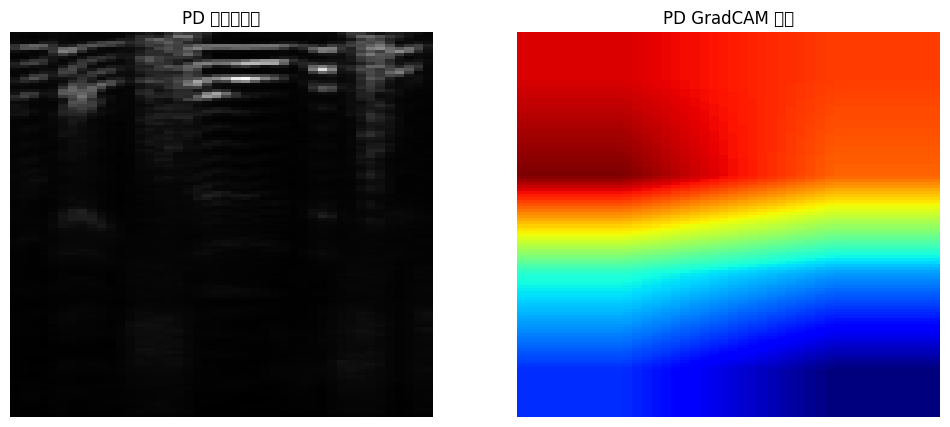

【解读】
生成的音频为经过 GradCAM 掩码过滤后的频谱逆变换结果，
可以听出模型在 PD 样本中最关注的频谱区域的声音信息；
如果该部分声音与 HC 样本明显不同，则说明这些频段可能反映出 PD 特有的异常能量分布或震颤现象。


In [10]:
import os
import numpy as np
import librosa
import librosa.display
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.display import Audio, display

########################################
# GradCAM 类（参考 Selvaraju et al., ICCV 2017）
########################################
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
        
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))
        
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
            
    def __call__(self, input_tensor, target_class):
        self.model.zero_grad()
        output = self.model(input_tensor)
        # 判断输出维度，处理 1D 或 2D 输出
        if output.dim() == 1:
            score = output[target_class]
        elif output.dim() == 2:
            score = output[0, target_class]
        else:
            raise ValueError("Unexpected output dimension")
        score.backward()
        gradients = self.gradients  # shape: [1, C, H, W]
        activations = self.activations  # shape: [1, C, H, W]
        weights = gradients.mean(dim=(2, 3), keepdim=True)  # [1, C, 1, 1]
        cam_map = torch.relu((weights * activations).sum(dim=1, keepdim=True))
        cam_map = torch.nn.functional.interpolate(cam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam_map = cam_map.squeeze().cpu().numpy()
        # 归一化到 [0, 1]
        cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min() + 1e-8)
        return cam_map

########################################
# 读取频谱图并恢复幅值谱（假设原图是将 dB 从 [-80, 0] 线性映射到 [0,255]）
########################################
def load_magnitude_from_image(image_path, min_db=-80, max_db=0):
    """
    加载灰度图像并将像素值反映射回 dB 值，再转换为幅值谱。
    假设图像保存时将 dB 值从 [min_db, max_db] 线性映射到了 [0,255]。
    """
    img = Image.open(image_path).convert("L")
    img_np = np.array(img).astype(np.float32)  # 像素值在 [0,255]
    norm = img_np / 255.0  # 归一化到 [0,1]
    # 反向映射到 dB: dB = norm * (max_db - min_db) + min_db
    db = norm * (max_db - min_db) + min_db
    # 转换为幅值谱：幅值 = 10^(dB/20)
    magnitude = np.power(10, db / 20)
    return magnitude

########################################
# 生成“判别性”频谱并逆变换为音频
########################################
def generate_discriminative_audio(image_path, model, target_class, device="cuda", min_db=-80):
    """
    1. 加载原始频谱图图像，恢复出幅值谱（magnitude）
    2. 对输入图像使用 ToTensor 得到 input_tensor（供模型计算 GradCAM 用）
    3. 利用 GradCAM 计算掩码（mask）
    4. 将掩码应用于幅值谱，得到判别性幅值谱
    5. 根据恢复的幅值谱尺寸，动态推断 n_fft 并设置 hop_length
    6. 利用 Griffin-Lim 算法逆变换生成音频
    返回生成的音频波形
    """
    transform = transforms.ToTensor()
    # 加载图像（RGB）用于模型输入
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # 计算 GradCAM 掩码
    gradcam = GradCAM(model, model.layer4)  # 以 ResNet18 的最后一个卷积层为目标层
    cam_mask = gradcam(input_tensor, target_class)
    gradcam.remove_hooks()
    
    # 加载原始幅值谱（恢复自保存的频谱图）
    magnitude = load_magnitude_from_image(image_path, min_db=min_db)
    
    # 调整 cam_mask 到与 magnitude 同尺寸（如果需要）
    if cam_mask.shape != magnitude.shape:
        cam_mask = np.array(Image.fromarray((cam_mask*255).astype(np.uint8)).resize((magnitude.shape[1], magnitude.shape[0]), resample=Image.BILINEAR)) / 255.0
    
    # 应用掩码，得到判别性幅值谱
    masked_magnitude = magnitude * cam_mask
    
    # 动态推断 n_fft：假设 image 高度 H = n_fft//2 + 1
    H, T = masked_magnitude.shape
    n_fft_est = (H - 1) * 2
    hop_length = n_fft_est // 4  # 可根据需要调整

    # 使用 Griffin-Lim 算法进行逆变换
    waveform = librosa.griffinlim(masked_magnitude, n_iter=32, n_fft=n_fft_est, hop_length=hop_length)
    return waveform

########################################
# 主函数：生成 PD 与 HC 判别性音频并播放
########################################
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # 加载预训练的 ResNet18 模型，并修改最后一层（可加载微调权重）
    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    # 如果有微调权重，可使用 model.load_state_dict(torch.load("model_finetuned.pth", map_location=device))
    model = model.to(device)
    model.eval()
    
    # 指定 PD 与 HC 样本的频谱图路径（请根据实际情况修改路径）
    pd_image_path = "./Voice/standard/PD/ID02_pd_2_0_0_seg0_seg0_mel.png"
    hc_image_path = "./Voice/standard/HC/25-a_lhl_seg1_seg0_cqt.png"
    
    # 目标类别：假设 PD -> 1, HC -> 0
    print("生成 PD 判别性音频...")
    pd_waveform = generate_discriminative_audio(pd_image_path, model, target_class=1, device=device)
    print("生成 HC 判别性音频...")
    hc_waveform = generate_discriminative_audio(hc_image_path, model, target_class=0, device=device)
    
    # 保存生成的音频到文件（需要安装 soundfile：pip install soundfile）
    import soundfile as sf
    sf.write("discriminative_pd.wav", pd_waveform, samplerate=22050)
    sf.write("discriminative_hc.wav", hc_waveform, samplerate=22050)
    
    # 播放生成的音频（在 Jupyter 中可直接显示 Audio 对象）
    print("播放 PD 判别性音频:")
    display(Audio(pd_waveform, rate=22050))
    
    print("播放 HC 判别性音频:")
    display(Audio(hc_waveform, rate=22050))
    
    # 同时展示 PD 样本的原始幅值谱与 GradCAM 掩码对比
    pd_magnitude = load_magnitude_from_image(pd_image_path)
    transform = transforms.ToTensor()
    pd_img = Image.open(pd_image_path).convert("RGB")
    input_tensor = transform(pd_img).unsqueeze(0).to(device)
    gradcam = GradCAM(model, model.layer4)
    pd_cam = gradcam(input_tensor, target_class=1)
    gradcam.remove_hooks()
    if pd_cam.shape != pd_magnitude.shape:
        pd_cam = np.array(Image.fromarray((pd_cam*255).astype(np.uint8)).resize((pd_magnitude.shape[1], pd_magnitude.shape[0]), resample=Image.BILINEAR)) / 255.0

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(pd_magnitude, cmap="gray", aspect="auto")
    plt.title("PD Original Amplitude Spectrum")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(pd_cam, cmap="jet", aspect="auto")
    plt.title("PD GradCAM Mask")
    plt.axis("off")
    plt.show()
    
    print("【解读】")
    print("生成的音频为经过 GradCAM 掩码过滤后的频谱逆变换结果，")
    print("可以听出模型在 PD 样本中最关注的频谱区域的声音信息；")
    print("如果该部分声音与 HC 样本明显不同，则说明这些频段可能反映出 PD 特有的异常能量分布或震颤现象。")
    
if __name__ == "__main__":
    main()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_masked_magnitude(masked_magnitude, save_csv_path=None):
    """
    输入为模型关注区域提取后的频谱图（masked magnitude），单位为 amplitude。
    可打印统计值、频率分布图，并可导出为 CSV。
    """
    H, T = masked_magnitude.shape  # H = 频率方向，T = 时间帧

    # 1️⃣ 统计信息
    print("🔍 判别性频谱图统计（单位为 amplitude）")
    print(f"大小: {H} (频率 bins) x {T} (时间帧)")
    print(f"最小值: {masked_magnitude.min():.6f}")
    print(f"最大值: {masked_magnitude.max():.6f}")
    print(f"均值: {masked_magnitude.mean():.6f}")
    print(f"中位数: {np.median(masked_magnitude):.6f}")
    print(f"非零像素占比: {np.mean(masked_magnitude > 0)*100:.2f}%")
    
    # 2️⃣ 每个频率 bin 的平均幅值（可观察模型最关注的频率范围）
    freq_profile = masked_magnitude.mean(axis=1)
    time_profile = masked_magnitude.mean(axis=0)
    
    # 3️⃣ 可视化
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    
    sns.heatmap(masked_magnitude, ax=ax[0], cmap='magma', cbar=True)
    ax[0].set_title("判别性频谱图（amplitude）")
    ax[0].set_xlabel("时间帧")
    ax[0].set_ylabel("频率 bins")
    
    ax[1].plot(freq_profile[::-1])  # 低频在下方
    ax[1].set_title("频率能量分布 (从低频到高频)")
    ax[1].set_ylabel("平均 amplitude")

    ax[2].plot(time_profile)
    ax[2].set_title("时间能量分布")
    ax[2].set_ylabel("平均 amplitude")
    
    plt.tight_layout()
    plt.show()
    
    # 4️⃣ 可选：保存为 CSV
    if save_csv_path:
        df = pd.DataFrame(masked_magnitude)
        df.to_csv(save_csv_path, index=False)
        print(f"✅ 已保存特征频谱为 CSV：{save_csv_path}")


Found 1253 audio files.
[18:13:49] Processing file 1/1253: /Users/beibeiliu/paper/explore/Voice/China_HC/HC/滨江水岸社区卫生服务站 3.wav
[18:13:50] Processing file 2/1253: /Users/beibeiliu/paper/explore/Voice/China_HC/HC/滨江水岸社区卫生服务站 2.wav
[18:13:50] Processing file 3/1253: /Users/beibeiliu/paper/explore/Voice/China_HC/HC/滨江水岸社区卫生服务站 4.wav
[18:13:50] Processing file 4/1253: /Users/beibeiliu/paper/explore/Voice/China_HC/HC/滨江水岸社区卫生服务站.wav
[18:13:50] Processing file 5/1253: /Users/beibeiliu/paper/explore/Voice/China_HC/HC/滨江水岸社区卫生服务站 14.wav
[18:13:50] Processing file 6/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/135/135-a_l.wav
[18:13:50] Processing file 7/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/135/135-a_n.wav
[18:13:50] Processing file 8/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/135/135-a_h.wav
[18:13:50] Processing file 9/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/135/135-i_l.wav
[18:13:50] Processing file 10/1253: /Users/beib

[18:13:52] Processing file 87/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/35/35-phrase.wav
[18:13:52] Processing file 88/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/35/35-i_l.wav
[18:13:52] Processing file 89/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/35/35-a_lhl.wav
[18:13:52] Processing file 90/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/35/35-i_n.wav
Processed 90/1253 files.
[18:13:52] Processing file 91/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/35/35-u_n.wav
[18:13:52] Processing file 92/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/35/35-u_l.wav
[18:13:52] Processing file 93/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/35/35-u_h.wav
[18:13:52] Processing file 94/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/35/35-a_h.wav
[18:13:52] Processing file 95/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/35/35-a_l.wav
[18:13:52] Processing file 96/1253

Processed 170/1253 files.
[18:13:53] Processing file 171/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/94/94-a_l.wav
[18:13:53] Processing file 172/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/94/94-a_n.wav
[18:13:53] Processing file 173/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/94/94-phrase.wav
[18:13:53] Processing file 174/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/94/94-a_h.wav
[18:13:53] Processing file 175/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/34/34-i_n.wav
[18:13:53] Processing file 176/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/34/34-i_l.wav
[18:13:53] Processing file 177/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/34/34-i_h.wav
[18:13:53] Processing file 178/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/34/34-i_lhl.wav
[18:13:53] Processing file 179/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/34/34-u_h.wav
[18:13:53] Processing fi

[18:13:55] Processing file 256/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/27/27-u_lhl.wav
[18:13:55] Processing file 257/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/27/27-u_l.wav
[18:13:55] Processing file 258/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/27/27-i_l.wav
[18:13:55] Processing file 259/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/27/27-i_n.wav
[18:13:55] Processing file 260/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/27/27-i_h.wav
Processed 260/1253 files.
[18:13:55] Processing file 261/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/27/27-a_l.wav
[18:13:55] Processing file 262/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/27/27-a_n.wav
[18:13:55] Processing file 263/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/27/27-a_h.wav
[18:13:55] Processing file 264/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/27/27-phrase.wav
[18:13:55] Processing fi

Processed 340/1253 files.
[18:13:56] Processing file 341/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/116/116-a_l.wav
[18:13:56] Processing file 342/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/116/116-a_n.wav
[18:13:56] Processing file 343/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/45/45-u_h.wav
[18:13:56] Processing file 344/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/45/45-u_n.wav
[18:13:56] Processing file 345/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/45/45-u_l.wav
[18:13:56] Processing file 346/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/45/45-i_l.wav
[18:13:56] Processing file 347/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/45/45-a_lhl.wav
[18:13:56] Processing file 348/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/45/45-i_n.wav
[18:13:56] Processing file 349/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/45/45-u_lhl.wav
[18:13:56] Processing

[18:13:58] Processing file 424/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/10/10-i_h.wav
[18:13:58] Processing file 425/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/10/10-i_l.wav
[18:13:58] Processing file 426/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/10/10-i_n.wav
[18:13:58] Processing file 427/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/10/10-a_lhl.wav
[18:13:58] Processing file 428/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/10/10-a_h.wav
[18:13:58] Processing file 429/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/10/10-a_l.wav
[18:13:58] Processing file 430/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/10/10-i_lhl.wav
Processed 430/1253 files.
[18:13:58] Processing file 431/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/10/10-u_lhl.wav
[18:13:58] Processing file 432/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/10/10-a_n.wav
[18:13:58] Processing f

[18:13:59] Processing file 507/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/86/86-i_l.wav
[18:13:59] Processing file 508/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/86/86-i_n.wav
[18:13:59] Processing file 509/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/86/86-a_h.wav
[18:13:59] Processing file 510/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/86/86-a_l.wav
Processed 510/1253 files.
[18:13:59] Processing file 511/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/86/86-a_n.wav
[18:13:59] Processing file 512/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/72/72-u_n.wav
[18:13:59] Processing file 513/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/72/72-u_l.wav
[18:13:59] Processing file 514/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/72/72-u_h.wav
[18:13:59] Processing file 515/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/72/72-i_h.wav
[18:13:59] Processing file 51

Processed 590/1253 files.
[18:14:01] Processing file 591/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/38/38-i_lhl.wav
[18:14:01] Processing file 592/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/38/38-a_n.wav
[18:14:01] Processing file 593/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/38/38-a_l.wav
[18:14:01] Processing file 594/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/38/38-phrase.wav
[18:14:01] Processing file 595/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/38/38-a_lhl.wav
[18:14:01] Processing file 596/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/38/38-u_l.wav
[18:14:01] Processing file 597/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/38/38-u_n.wav
[18:14:01] Processing file 598/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/38/38-u_h.wav
[18:14:01] Processing file 599/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/38/38-i_h.wav
[18:14:01] Processing 

[18:14:02] Processing file 675/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/54/54-i_h.wav
[18:14:02] Processing file 676/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/54/54-i_n.wav
[18:14:02] Processing file 677/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/54/54-i_l.wav
[18:14:02] Processing file 678/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/54/54-a_h.wav
[18:14:02] Processing file 679/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/54/54-u_lhl.wav
[18:14:02] Processing file 680/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/54/54-i_lhl.wav
Processed 680/1253 files.
[18:14:02] Processing file 681/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/54/54-a_n.wav
[18:14:02] Processing file 682/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/54/54-a_lhl.wav
[18:14:02] Processing file 683/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/54/54-a_l.wav
[18:14:02] Processing f

[18:14:04] Processing file 759/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/55/55-u_lhl.wav
[18:14:04] Processing file 760/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/55/55-i_lhl.wav
Processed 760/1253 files.
[18:14:04] Processing file 761/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/55/55-a_lhl.wav
[18:14:04] Processing file 762/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/137/137-a_h.wav
[18:14:04] Processing file 763/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/137/137-a_l.wav
[18:14:04] Processing file 764/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/137/137-a_n.wav
[18:14:04] Processing file 765/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/137/137-a_lhl.wav
[18:14:04] Processing file 766/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/137/137-i_lhl.wav
[18:14:04] Processing file 767/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/137/137-u_lhl.wav
[18:1

[18:14:05] Processing file 843/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/112/112-u_n.wav
[18:14:05] Processing file 844/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/112/112-i_lhl.wav
[18:14:05] Processing file 845/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/112/112-u_l.wav
[18:14:05] Processing file 846/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/112/112-u_lhl.wav
[18:14:05] Processing file 847/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/112/112-a_lhl.wav
[18:14:05] Processing file 848/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/112/112-u_h.wav
[18:14:05] Processing file 849/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/115/115-i_h.wav
[18:14:05] Processing file 850/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/115/115-i_n.wav
Processed 850/1253 files.
[18:14:05] Processing file 851/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/115/115-i_l.wav
[18:1

[18:14:06] Processing file 919/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/70/70-u_lhl.wav
[18:14:06] Processing file 920/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/70/70-u_l.wav
Processed 920/1253 files.
[18:14:06] Processing file 921/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/70/70-i_lhl.wav
[18:14:06] Processing file 922/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/70/70-phrase.wav
[18:14:07] Processing file 923/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/70/70-a_l.wav
[18:14:07] Processing file 924/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/70/70-a_n.wav
[18:14:07] Processing file 925/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/84/84-i_l.wav
[18:14:07] Processing file 926/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/84/84-i_n.wav
[18:14:07] Processing file 927/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/84/84-i_h.wav
[18:14:07] Processing 

[18:14:08] Processing file 1002/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/12/12-a_h.wav
[18:14:08] Processing file 1003/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/71/71-i_h.wav
[18:14:08] Processing file 1004/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/71/71-a_lhl.wav
[18:14:08] Processing file 1005/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/71/71-u_lhl.wav
[18:14:08] Processing file 1006/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/71/71-i_n.wav
[18:14:08] Processing file 1007/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/71/71-i_l.wav
[18:14:08] Processing file 1008/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/71/71-phrase.wav
[18:14:08] Processing file 1009/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/71/71-i_lhl.wav
[18:14:08] Processing file 1010/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/71/71-u_l.wav
Processed 1010/1253 files.
[18:14:08]

[18:14:09] Processing file 1087/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/47/47-u_lhl.wav
[18:14:09] Processing file 1088/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/47/47-a_n.wav
[18:14:09] Processing file 1089/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/47/47-i_lhl.wav
[18:14:09] Processing file 1090/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/113/113-a_n.wav
Processed 1090/1253 files.
[18:14:09] Processing file 1091/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/113/113-a_l.wav
[18:14:10] Processing file 1092/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/113/113-a_h.wav
[18:14:10] Processing file 1093/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/113/113-i_n.wav
[18:14:10] Processing file 1094/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/113/113-i_lhl.wav
[18:14:10] Processing file 1095/1253: /Users/beibeiliu/paper/explore/Voice/German_HC/Female/113/113-i_l.wav
[

[18:14:11] Processing file 1169/1253: /Users/beibeiliu/paper/explore/Voice/KCL_Text_HC/ID14_hc_0_0_0.wav
[18:14:11] Processing file 1170/1253: /Users/beibeiliu/paper/explore/Voice/KCL_Text_HC/ID25_hc_0_0_0.wav
Processed 1170/1253 files.
[18:14:11] Processing file 1171/1253: /Users/beibeiliu/paper/explore/Voice/KCL_Text_HC/ID22_hc_0_0_0.wav
[18:14:11] Processing file 1172/1253: /Users/beibeiliu/paper/explore/Voice/KCL_Text_HC/ID12_hc_0_0_0.wav
[18:14:11] Processing file 1173/1253: /Users/beibeiliu/paper/explore/Voice/KCL_Text_HC/ID15_hc_0_0_0.wav
[18:14:11] Processing file 1174/1253: /Users/beibeiliu/paper/explore/Voice/KCL_Text_HC/ID00_hc_0_0_0.wav
[18:14:11] Processing file 1175/1253: /Users/beibeiliu/paper/explore/Voice/KCL_Text_HC/ID36_hc_0_0_0.wav
[18:14:11] Processing file 1176/1253: /Users/beibeiliu/paper/explore/Voice/KCL_Text_HC/ID23_hc_0_0_0.wav
[18:14:11] Processing file 1177/1253: /Users/beibeiliu/paper/explore/Voice/KCL_Text_HC/ID28_hc_0_0_0.wav
[18:14:11] Processing file 1

[18:14:14] Processing file 1244/1253: /Users/beibeiliu/paper/explore/Voice/German_PD/1580-i_n.wav
[18:14:14] Processing file 1245/1253: /Users/beibeiliu/paper/explore/Voice/German_PD/1580-i_l.wav
[18:14:14] Processing file 1246/1253: /Users/beibeiliu/paper/explore/Voice/German_PD/1580-phrase.wav
[18:14:14] Processing file 1247/1253: /Users/beibeiliu/paper/explore/Voice/German_PD/1580-i_h.wav
[18:14:14] Processing file 1248/1253: /Users/beibeiliu/paper/explore/Voice/German_PD/1580-a_n.wav
[18:14:14] Processing file 1249/1253: /Users/beibeiliu/paper/explore/Voice/German_PD/1580-a_l.wav
[18:14:14] Processing file 1250/1253: /Users/beibeiliu/paper/explore/Voice/German_PD/1580-a_h.wav
Processed 1250/1253 files.
[18:14:14] Processing file 1251/1253: /Users/beibeiliu/paper/explore/Voice/German_PD/1580-i_lhl.wav
[18:14:14] Processing file 1252/1253: /Users/beibeiliu/paper/explore/Voice/German_PD/1580-u_lhl.wav
[18:14:14] Processing file 1253/1253: /Users/beibeiliu/paper/explore/Voice/German_PD

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28392 (\N{CJK UNIFIED IDEOGRAPH-6EE8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27743 (\N{CJK UNIFIED IDEOGRAPH-6C5F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27700 (\N{CJK UNIFIED IDEOGRAPH-6C34}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23736 (\N{CJK UNIFIED IDEOGRAPH-5CB8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31038 (\N{CJK U

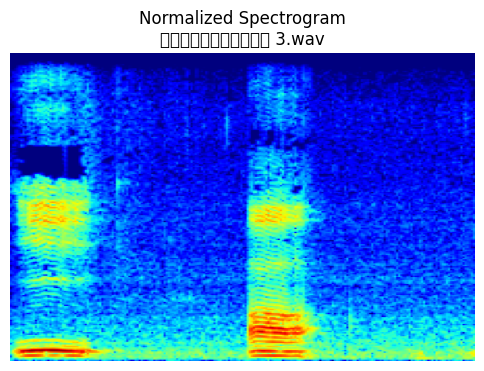

In [4]:
import os
import glob
import librosa
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.feature import hog
import time
import pandas as pd

# -------------------------------
# 参数设置
# -------------------------------
TARGET_SR = 16000           # 目标采样率
TARGET_DURATION = 3.0       # 目标时长（秒）
TARGET_SHAPE = (224, 224)   # 归一化后的频谱图尺寸
REMOVE_SILENCE = True       # 是否去除静音

# -------------------------------
# 音频预处理：加载、静音裁剪、时长归一化
# -------------------------------
def process_audio_file(file_path, target_sr=TARGET_SR, target_duration=TARGET_DURATION, remove_silence=True):
    # 加载音频，统一采样率
    y, sr = librosa.load(file_path, sr=target_sr)
    if remove_silence:
        y, _ = librosa.effects.trim(y, top_db=20)
    target_length = int(target_sr * target_duration)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)), mode='constant')
    else:
        y = y[:target_length]
    return y, sr

# -------------------------------
# 生成频谱图
# -------------------------------
def generate_spectrogram(y, sr, n_fft=512, hop_length=256):
    # 计算STFT，转换为幅度谱的dB表示
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    return S_db

# -------------------------------
# 归一化频谱图到固定尺寸
# -------------------------------
def resize_spectrogram(spectrogram, target_shape=TARGET_SHAPE):
    # 利用skimage.transform.resize调整尺寸，并归一化到0-1
    spec_resized = resize(spectrogram, target_shape, mode='reflect', anti_aliasing=True)
    spec_min, spec_max = spec_resized.min(), spec_resized.max()
    spec_norm = (spec_resized - spec_min) / (spec_max - spec_min + 1e-8)
    return spec_norm

# -------------------------------
# 提取图像特征（例如HOG特征）
# -------------------------------
def extract_features_from_spectrogram(spectrogram):
    # 使用HOG提取特征向量
    fd, hog_image = hog(spectrogram, orientations=9, pixels_per_cell=(16, 16),
                        cells_per_block=(2, 2), visualize=True, feature_vector=True)
    return fd

# -------------------------------
# 整合音频处理、频谱生成与特征提取
# -------------------------------
def process_and_extract(file_path):
    try:
        y, sr = process_audio_file(file_path, target_sr=TARGET_SR, target_duration=TARGET_DURATION, remove_silence=REMOVE_SILENCE)
        spec = generate_spectrogram(y, sr)
        spec_resized = resize_spectrogram(spec, target_shape=TARGET_SHAPE)
        features = extract_features_from_spectrogram(spec_resized)
        return spec_resized, features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

# -------------------------------
# 标签判定函数：根据文件路径判断 PD 或 HC
# -------------------------------
def determine_label(file_path):
    path_lower = file_path.lower()
    if "pd" in path_lower:
        return "PD"
    else:
        return "HC"

# -------------------------------
# 主函数：遍历处理所有音频文件
# -------------------------------
def main():
    root_dir = "/Users/beibeiliu/paper/explore/Voice"
    pattern = os.path.join(root_dir, '**', '*.wav')
    file_paths = glob.glob(pattern, recursive=True)
    total_files = len(file_paths)
    print(f"Found {total_files} audio files.")
    
    results = []
    start_time = time.time()
    for idx, file_path in enumerate(file_paths):
        print(f"[{time.strftime('%H:%M:%S')}] Processing file {idx+1}/{total_files}: {file_path}")
        spec, features = process_and_extract(file_path)
        if spec is not None and features is not None:
            label = determine_label(file_path)
            results.append({
                "file": file_path,
                "label": label,
                "features": features
            })
        # 实时返回进度
        if (idx+1) % 10 == 0:
            print(f"Processed {idx+1}/{total_files} files.")
    elapsed = time.time() - start_time
    print(f"Processed {total_files} files in {elapsed:.2f} seconds.")
    
    # 保存结果到DataFrame
    df = pd.DataFrame(results)
    
    # 分组统计PD与HC特征（这里以HOG特征为例，输出前10个维度的均值）
    pd_features = np.array([r["features"] for r in results if r["label"]=="PD"])
    hc_features = np.array([r["features"] for r in results if r["label"]=="HC"])
    if pd_features.size > 0:
        pd_mean = np.mean(pd_features, axis=0)
        print("PD features mean (first 10 dims):", pd_mean[:10])
    else:
        print("No PD samples processed.")
    if hc_features.size > 0:
        hc_mean = np.mean(hc_features, axis=0)
        print("HC features mean (first 10 dims):", hc_mean[:10])
    else:
        print("No HC samples processed.")
    
    # 可选：保存结果
    df.to_pickle("audio_features.pkl")
    print("Saved extracted features to audio_features.pkl")
    
    # 可选：展示一个归一化后的频谱图示例
    if total_files > 0:
        example_spec, _ = process_and_extract(file_paths[0])
        plt.figure(figsize=(6,4))
        plt.imshow(example_spec, cmap='jet', aspect='auto', origin='lower')
        plt.title(f"Normalized Spectrogram\n{os.path.basename(file_paths[0])}")
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    main()


In [15]:
import os
import random
import glob
from dataclasses import dataclass
from typing import List, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

########################################
# 0. 复现性：统一随机种子
########################################

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

########################################
# 1. 数据集定义及划分（支持单频谱 / 多频谱）
########################################

class SpectrogramDataset(torch.utils.data.Dataset):
    """根据 spec_mode 过滤频谱类型；支持 multi/constantq/scalogram"""

    def __init__(self, root_dir: str, transform=None, spec_mode: str = "multi"):
        self.root_dir = root_dir
        self.transform = transform
        pattern = os.path.join(root_dir, "**", "*Output", "*.png")
        all_paths = glob.glob(pattern, recursive=True)

        # 根据 spec_mode 过滤
        if spec_mode == "constantq":
            self.image_paths = [p for p in all_paths if "constantq" in p.lower()]
        elif spec_mode == "scalogram":
            self.image_paths = [p for p in all_paths if "scalogram" in p.lower()]
        else:  # multi
            self.image_paths = all_paths

        if len(self.image_paths) == 0:
            raise ValueError("未找到符合条件的 png 文件，请检查路径及 spec_mode。")

        self.labels = []
        for path in self.image_paths:
            path_lower = path.lower()
            folder_name = os.path.basename(os.path.dirname(path_lower))
            file_name = os.path.basename(path_lower)
            self.labels.append(1 if ("pd" in folder_name or "pd" in file_name) else 0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        spec_type = (
            "constantq"
            if "constantq" in img_path.lower()
            else ("scalogram" if "scalogram" in img_path.lower() else "unknown")
        )
        if self.transform is not None:
            image = self.transform(image, spec_type)
        return image, self.labels[idx]

########################################
# 2. 预处理 + 全局-局部增强（可开关）
########################################

def crop_spectrogram(image: Image.Image, std_ratio: float = 0.1):
    gray = image.convert("L")
    img_np = np.array(gray, dtype=np.float32)
    row_std = np.std(img_np, axis=1)
    col_std = np.std(img_np, axis=0)
    row_thresh = np.max(row_std) * std_ratio
    col_thresh = np.max(col_std) * std_ratio
    rows = np.where(row_std > row_thresh)[0]
    cols = np.where(col_std > col_thresh)[0]
    if rows.size == 0 or cols.size == 0:
        return image
    top, bottom = int(rows[0]), int(rows[-1])
    left, right = int(cols[0]), int(cols[-1])
    return image.crop((left, top, right, bottom))


class GlobalLocalTransform:
    def __init__(self, output_size=(224, 224), enable_aug: bool = True):
        self.output_size = output_size
        self.enable_aug = enable_aug
        self.local_transform = transforms.RandomErasing(
            p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)
        )

    def __call__(self, image: Image.Image, spec_type: str):
        image = crop_spectrogram(image, std_ratio=0.1)
        image = image.resize(self.output_size, Image.BILINEAR)
        image = transforms.ToTensor()(image)

        if not self.enable_aug:
            return image  # 关闭增强直接返回

        image_global = self.global_transform(image, spec_type)
        image_local = self.local_transform(image.clone())
        alpha = random.uniform(0, 1)
        image_aug = torch.clamp(alpha * image_global + (1 - alpha) * image_local, 0, 1)
        return image_aug

    def global_transform(self, image: torch.Tensor, spec_type: str):
        C, H, W = image.shape
        image_fft = torch.fft.fft2(image)
        cx, cy = W // 2, H // 2
        grid_y, grid_x = torch.meshgrid(
            torch.arange(H, device=image.device),
            torch.arange(W, device=image.device),
            indexing="ij",
        )
        distance = torch.sqrt((grid_x - cx) ** 2 + (grid_y - cy) ** 2)
        if spec_type == "constantq":
            r = random.uniform(0.1, 0.3) * max(W, H)
        elif spec_type == "scalogram":
            r = random.uniform(0.2, 0.4) * max(W, H)
        else:
            r = random.uniform(0.1, 0.3) * max(W, H)
        mask = (distance < r).float().unsqueeze(0).repeat(C, 1, 1)
        noise = torch.randn_like(image_fft) * 0.1
        image_fft_aug = image_fft * mask + noise
        return torch.fft.ifft2(image_fft_aug).real

########################################
# 3. 模型：CausalSpectroNet（可选因果注意力）
########################################

class CausalSpectroNet(nn.Module):
    def __init__(self, num_classes: int = 2, use_causal_attention: bool = True):
        super().__init__()
        backbone = torchvision.models.resnet18(
            weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        )
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])
        self.use_causal_attention = use_causal_attention
        if use_causal_attention:
            self.attention = nn.Conv2d(512, 1, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)  # (B, 512, H, W)
        if self.use_causal_attention:
            att_map = torch.sigmoid(self.attention(features))
            features = features * att_map
        pooled = self.avgpool(features).view(x.size(0), -1)
        return self.fc(pooled)

########################################
# 4. 训练与评估（单次）
########################################

def train_one_epoch(model, dataloader, optimizer, device, class_weights):
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            preds = torch.argmax(model(images), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

########################################
# 5. 实验配置 & 多次独立实验 + 统计显著性
########################################

@dataclass
class ExperimentConfig:
    name: str
    use_global_local_aug: bool = True
    spec_mode: str = "multi"  # multi | constantq | scalogram
    use_causal_attention: bool = True


def run_experiment(cfg: ExperimentConfig, seed: int, root_dir: str, device):
    set_seed(seed)
    transform = GlobalLocalTransform(enable_aug=cfg.use_global_local_aug)
    dataset = SpectrogramDataset(root_dir=root_dir, transform=transform, spec_mode=cfg.spec_mode)

    # 类别均衡权重
    counts = [dataset.labels.count(i) for i in range(2)]
    beta = 0.9999
    weights = torch.tensor(
        [((1 - beta) / (1 - beta ** c)) if c > 0 else 0 for c in counts], dtype=torch.float
    )
    weights = weights / weights.sum() * 2

    # 划分 8/1/1
    total_len = len(dataset)
    lengths = [int(0.8 * total_len), int(0.1 * total_len)]
    lengths.append(total_len - sum(lengths))
    train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, lengths)

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=16)

    model = CausalSpectroNet(use_causal_attention=cfg.use_causal_attention).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for _ in range(5):  # 较少 epoch 加快实验
        train_one_epoch(model, train_loader, optimizer, device, class_weights=weights)
    acc = evaluate(model, test_loader, device)
    return acc


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    root_dir = "./Voice"  # 修改为你的路径

    configs = [
        ExperimentConfig(name="Baseline (All modules)"),
        ExperimentConfig(name="No Global-Local Aug", use_global_local_aug=False),
        ExperimentConfig(name="Constant-Q only", spec_mode="constantq"),
        ExperimentConfig(name="Scalogram only", spec_mode="scalogram"),
        ExperimentConfig(name="No Causal Attention", use_causal_attention=False),
    ]

    seeds = [0, 1, 2]
    results: Dict[str, List[float]] = {cfg.name: [] for cfg in configs}

    for cfg in configs:
        for s in seeds:
            acc = run_experiment(cfg, s, root_dir, device)
            results[cfg.name].append(acc)
            print(f"{cfg.name} | Seed {s} | Acc: {acc:.4f}")

    # 统计 & t 检验
    baseline_scores = results[configs[0].name]
    rows = []
    for cfg in configs:
        scores = results[cfg.name]
        mean = np.mean(scores)
        std = np.std(scores)
        if cfg is configs[0]:
            p = np.nan
        else:
            _, p = stats.ttest_ind(baseline_scores, scores, equal_var=False)
        rows.append({"Config": cfg.name, "Mean": mean, "Std": std, "p vs Baseline": p})

    df = pd.DataFrame(rows)
    print("\n=== Ablation Results ===")
    print(df)

    # 可视化
    df.plot(x="Config", y="Mean", kind="bar", yerr="Std", legend=False)
    plt.ylabel("Accuracy")
    plt.title("Ablation Study")
    plt.tight_layout()
    plt.savefig("ablation_bar.png")
    print("Bar plot saved to ablation_bar.png")


if __name__ == "__main__":
    main()


ValueError: 未找到符合条件的 png 文件，请检查路径及 spec_mode。

In [ ]:
import os
import random
import glob
import json
from dataclasses import dataclass
from typing import List, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

########################################
# 0. 通用工具函数
########################################

def set_seed(seed: int = 42):
    """保证可复现"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

########################################
# 1. 数据集与预处理
########################################

def crop_spectrogram(image, std_ratio: float = 0.1):
    gray = image.convert('L')
    img_np = np.array(gray, dtype=np.float32)
    row_std = np.std(img_np, axis=1)
    col_std = np.std(img_np, axis=0)
    row_thresh = np.max(row_std) * std_ratio
    col_thresh = np.max(col_std) * std_ratio
    rows = np.where(row_std > row_thresh)[0]
    cols = np.where(col_std > col_thresh)[0]
    if rows.size == 0 or cols.size == 0:
        return image
    top, bottom = int(rows[0]), int(rows[-1])
    left, right = int(cols[0]), int(cols[-1])
    return image.crop((left, top, right, bottom))


class GlobalLocalTransform:
    """可开关的局部-全局增强"""
    def __init__(self, output_size=(224, 224), enable: bool = True):
        self.output_size = output_size
        self.enable = enable
        self.local_transform = transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))

    def __call__(self, image, spec_type):
        # 0. 可选关闭增强
        if not self.enable:
            return transforms.ToTensor()(image.resize(self.output_size, Image.BILINEAR))
        # 1. 裁剪
        image = crop_spectrogram(image, std_ratio=0.1)
        # 2. resize
        image = image.resize(self.output_size, Image.BILINEAR)
        image = transforms.ToTensor()(image)
        # 3. GL 增强
        image_global = self.global_transform(image, spec_type)
        image_local = self.local_transform(image.clone())
        alpha = random.uniform(0, 1)
        image_aug = alpha * image_global + (1 - alpha) * image_local
        return torch.clamp(image_aug, 0, 1)

    def global_transform(self, image, spec_type):
        C, H, W = image.shape
        image_fft = torch.fft.fft2(image)
        cx, cy = W // 2, H // 2
        grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
        grid_x, grid_y = grid_x.to(image.device), grid_y.to(image.device)
        distance = torch.sqrt((grid_x - cx) ** 2 + (grid_y - cy) ** 2)
        if spec_type == "constantq":
            r = random.uniform(0.1, 0.3) * max(W, H)
        elif spec_type == "scalogram":
            r = random.uniform(0.2, 0.4) * max(W, H)
        else:
            r = random.uniform(0.1, 0.3) * max(W, H)
        mask = (distance < r).float().unsqueeze(0).repeat(C, 1, 1)
        noise = torch.randn_like(image_fft) * 0.1
        image_fft_aug = image_fft * mask + noise
        return torch.fft.ifft2(image_fft_aug).real


class SpectrogramDataset(torch.utils.data.Dataset):
    """支持多/单频谱模式的数据集"""
    def __init__(self, root_dir: str, transform, spec_mode: str = "multi"):
        self.root_dir = root_dir
        self.transform = transform
        self.spec_mode = spec_mode  # multi | constantq | scalogram
        pattern = os.path.join(root_dir, '**', '*Output', '*.png')
        all_paths = glob.glob(pattern, recursive=True)
        if len(all_paths) == 0:
            raise ValueError("未找到png文件")
        # 过滤
        self.image_paths = []
        for p in all_paths:
            lower = p.lower()
            if spec_mode == "multi":
                self.image_paths.append(p)
            elif spec_mode == "constantq" and "constantq" in lower:
                self.image_paths.append(p)
            elif spec_mode == "scalogram" and "scalogram" in lower:
                self.image_paths.append(p)
        if len(self.image_paths) == 0:
            raise ValueError(f"在{spec_mode}模式下未找到数据")
        # 标签
        self.labels = [1 if ("pd" in os.path.basename(os.path.dirname(p)).lower() or "pd" in os.path.basename(p).lower()) else 0 for p in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        spec_type = "constantq" if "constantq" in img_path.lower() else (
            "scalogram" if "scalogram" in img_path.lower() else "unknown")
        if self.transform:
            image = self.transform(image, spec_type)
        return image, self.labels[idx]

########################################
# 2. 模型：可开关因果注意力
########################################

class CausalSpectroNet(nn.Module):
    def __init__(self, num_classes: int = 2, use_causal: bool = True):
        super().__init__()
        backbone = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])
        self.use_causal = use_causal
        if use_causal:
            self.attention = nn.Conv2d(512, 1, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        if self.use_causal:
            att = torch.sigmoid(self.attention(feats))
            feats = feats * att
        pooled = self.avgpool(feats).view(x.size(0), -1)
        return self.fc(pooled)

########################################
# 3. 训练/验证函数（单epoch）
########################################

def run_single_epoch(model, loader, optimizer, device, criterion, train: bool = True):
    if train:
        model.train()
    else:
        model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
            running_loss += loss.item()
            pred = logits.argmax(1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), correct / total

########################################
# 4. 实验配置与主循环
########################################

@dataclass
class ExperimentConfig:
    name: str
    use_global_local_aug: bool = True
    spec_mode: str = "multi"  # multi | constantq | scalogram
    use_causal_attention: bool = True


def run_experiment(cfg: ExperimentConfig, seeds: List[int], root_dir: str, epochs: int = 5, batch_size: int = 16, lr: float = 1e-4):
    results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for sd in seeds:
        set_seed(sd)
        transform = GlobalLocalTransform(output_size=(224, 224), enable=cfg.use_global_local_aug)
        dataset = SpectrogramDataset(root_dir=root_dir, transform=transform, spec_mode=cfg.spec_mode)
        # 简单8/2划分
        total = len(dataset); trn_len = int(0.8 * total); val_len = total - trn_len
        trn_set, val_set = torch.utils.data.random_split(dataset, [trn_len, val_len])
        trn_loader = torch.utils.data.DataLoader(trn_set, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
        model = CausalSpectroNet(use_causal=cfg.use_causal_attention).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        for ep in range(epochs):
            run_single_epoch(model, trn_loader, optimizer, device, criterion, train=True)
        _, val_acc = run_single_epoch(model, val_loader, optimizer, device, criterion, train=False)
        results.append(val_acc)
    return results

########################################
# 5. 统计分析 & 可视化
########################################

def analyse_results(baseline: List[float], others: Dict[str, List[float]]):
    rows = []
    for name, vals in [("baseline", baseline), *others.items()]:
        rows.append({"config": name, "mean": np.mean(vals), "std": np.std(vals)})
    df = pd.DataFrame(rows)
    print("\n=== 结果汇总 ===")
    print(df)
    # 统计检验
    for name, vals in others.items():
        t, p = stats.ttest_ind(baseline, vals, equal_var=False)
        print(f"{name} vs baseline: t={t:.3f}, p={p:.4f}")
    # 可视化
    plt.figure(figsize=(6, 4))
    plt.bar(df['config'], df['mean'], yerr=df['std'])
    plt.ylabel('Accuracy')
    plt.title('Ablation Study')
    plt.tight_layout()
    plt.savefig('ablation_bar.png')
    print("柱状图已保存为 ablation_bar.png")

########################################
# 6. 入口
########################################

def main():
    ROOT = "/path/to/Voice"  # TODO: 修改为你的数据根目录
    seeds = [0, 1, 2, 3, 4]
    # 定义所有实验
    baseline_cfg = ExperimentConfig(name="baseline")
    cfgs = [
        baseline_cfg,
        ExperimentConfig(name="no_GL", use_global_local_aug=False),
        ExperimentConfig(name="constantq_only", spec_mode="constantq"),
        ExperimentConfig(name="scalogram_only", spec_mode="scalogram"),
        ExperimentConfig(name="no_causal", use_causal_attention=False),
    ]
    all_results = {}
    for cfg in cfgs:
        print(f"\n>>> Running {cfg.name} ...")
        accs = run_experiment(cfg, seeds, ROOT)
        all_results[cfg.name] = accs
        print(f"Accuracies: {accs}")
    baseline = all_results.pop("baseline")
    analyse_results(baseline, all_results)
    # 保存所有结果
    with open('ablation_results.json', 'w') as f:
        json.dump(all_results | {"baseline": baseline}, f, indent=2)
    print("所有结果已保存到 ablation_results.json")


if __name__ == "__main__":
    main()
